## Fault-Flow Relationship
Impact of fault severity and flow rate on state variable residuals.

In [1]:
# Library imports.
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute, SubcatchAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import numpy.random as nprnd
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
import time

# Local imports.
from urbansurge import swmm_model, analysis_tools, file_utils

## Fault in physical system

In [24]:
# Fault parameterization.
fault_type = 'diameter'
fault_component = 3
fault_values = np.linspace(0, 0.16667 * .75, 6)
fault_values = np.arange(0.02, 0.12, 0.02)
print(fault_values)

[0.02 0.04 0.06 0.08 0.1 ]


In [30]:
# Bulk Processing.
fault_type = 'diameter'
fault_value_bulk = {
#     1: np.linspace(0, 0.16667 * .75, 6),
#     2: np.linspace(0, 0.16667 * .75, 6),
#     3: np.linspace(0, 0.16667 * .75, 6),
    4: np.linspace(0, 0.16667 * .75, 6),
#     5: np.linspace(0, 0.16667 * .75, 6),
#     6: np.linspace(0, 0.25 * .75, 6),
#     7: np.linspace(0, 0.25 * .75, 6),
#     8: np.linspace(0, 0.25 * .75, 6),
#     9: np.linspace(0, 0.25 * .75, 6),
#     10: np.linspace(0, 0.25 * .75, 6),
#     11: np.linspace(0, 0.16667 * .75, 6),
#     12: np.linspace(0, 0.25 * .75, 6),
#     13: np.linspace(0, 0.16667 * .75, 6),
#     14: np.linspace(0, 0.25 * .75, 6),
#     15: np.linspace(0, 0.25 * .75, 6),
#     16: np.linspace(0, 0.25 * .75, 6),
#     17: np.linspace(0, 0.16667 * .75, 6),
#     18: np.linspace(0, 0.16667 * .75, 6),
#     19: np.linspace(0, 0.16667 * .75, 6),
}

# # Roughness.
# fault_type = 'roughness'
# fault_value_bulk = {
#     1: np.arange(0.02, 0.12, 0.02),
#     2: np.arange(0.02, 0.12, 0.02),
#     3: np.arange(0.02, 0.12, 0.02),
#     4: np.arange(0.02, 0.12, 0.02),
#     5: np.arange(0.02, 0.12, 0.02),
#     6: np.arange(0.02, 0.12, 0.02),
#     7: np.arange(0.02, 0.12, 0.02),
#     8: np.arange(0.02, 0.12, 0.02),
#     9: np.arange(0.02, 0.12, 0.02),
#     10: np.arange(0.02, 0.12, 0.02),
#     11: np.arange(0.02, 0.12, 0.02),
#     12: np.arange(0.02, 0.12, 0.02),
#     13: np.arange(0.02, 0.12, 0.02),
#     14: np.arange(0.02, 0.12, 0.02),
#     15: np.arange(0.02, 0.12, 0.02),
#     16: np.arange(0.02, 0.12, 0.02),
#     17: np.arange(0.02, 0.12, 0.02),
#     18: np.arange(0.02, 0.12, 0.02),
#     19: np.arange(0.02, 0.12, 0.02),
# }

# # Silting.
# fault_type = 'silting'
# fault_value_bulk = {
#     20: np.arange(0, 0.9, 0.1)
# }

print(fault_type)

diameter


In [31]:
# Path to configuration file.
config_path = r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Lab_System\lab_physical_config.yml"

for fault_component, fault_values in fault_value_bulk.items():

    output_df_list = []
    for fault_value in fault_values:
        print(f'FAULT VALUE: {fault_value}')

        # Create instance of SWMM model.
        swmm = swmm_model.SWMM(config_path)

        # Configure model.
        swmm.configure_model()

        if fault_type == 'diameter':
            # Assign fault variables.
            link_id = fault_component
            offset = fault_value

            # Get initial diameter.
            initial_geometry = swmm.get_link_geometry(link_id)
            initial_diameter = initial_geometry[0]

            # Update the link diameter.
            swmm.set_link_geometry(link_id, [initial_diameter - offset, 0, 0, 0])

            # Update the offsets.
            swmm.set_link_offsets(link_id, (offset, offset))

        elif fault_type == 'roughness':
            # Assign fault variables.
            link_id = fault_component
            n = fault_value

            # Update the link roughness.
            swmm.set_link_roughness(link_id, n)

        elif fault_type == 'seepage':
            # Assign fault variables.
            link_id = fault_component
            seepage_rate = fault_value

            # Update the link roughness.
            swmm.set_link_seepage(link_id, seepage_rate)

        elif fault_type == 'infiltration':
            # Assign fault variables.
            storage_id = fault_component
            Ksat = fault_value

            # Update the saturated hydraulic conductivity.
            swmm.set_storage_property(storage_id, 'Ksat', Ksat)

        elif fault_type == 'silting':
            # Assign fault variables.
            storage_id = fault_component
            silt_depth = fault_value

            # Get storage depth.
            Ds_init = swmm.get_storage_property(storage_id, 'MaxDepth')

            # Get conduit offsets.
            overflow_link_id = swmm.get_storage_outfall_link(storage_id)
            (in_offset_init, out_offset) = swmm.get_link_offsets(overflow_link_id)

            # Get the storage invert elevation.
            zi_init = swmm.get_storage_property(storage_id, 'Elev.')

            # Update the storage_depth.
            Ds = Ds_init - silt_depth
            swmm.set_storage_property(storage_id, 'MaxDepth', Ds)

            # Update conduit offset.
            in_offset = in_offset_init - silt_depth
            swmm.set_link_offsets(overflow_link_id, (in_offset, out_offset))

            # Update storage invert elevation.
            zi = zi_init + silt_depth
            swmm.set_storage_property(storage_id, 'Elev.', zi)

        # Run the simulation.
        swmm.run_simulation()

        # OUTPUT TO DATA FRAME
        # ---------------------------------------------------------------------
        # Get the node depths.
        node_depth_df = swmm.get_node_depth()

        # Get node flooding.
        node_flood_df = swmm.get_node_flooding()

        # Get node inflow.
        node_total_inflow_df = swmm.get_node_total_inflow()

        # Get link flow.
        link_flow_df = swmm.get_link_flow()

        # Get link depth.
        link_depth_df = swmm.get_link_depth()

        # Get link velocity.
        link_velocity_df = swmm.get_link_velocity()

        # Get precipitation time series.
        prcp_df = swmm.get_rainfall_timeseries()

        # Join data frames.
        fault_df = node_depth_df.merge(node_flood_df, on='datetime')
        fault_df = fault_df.merge(node_total_inflow_df, on='datetime')
        fault_df = fault_df.merge(link_flow_df, on='datetime')
        fault_df = fault_df.merge(link_depth_df, on='datetime')
        fault_df = fault_df.merge(link_velocity_df, on='datetime')
        fault_df = fault_df.merge(prcp_df, on='datetime')

        # Add fault type, component, and value.
        fault_df['fault_type'] = fault_type
        fault_df['fault_component'] = fault_component
        fault_df['fault_value'] = fault_value
        fault_df = fault_df.copy()

        output_df_list.append(fault_df)

    fault_df = pd.concat(output_df_list)

    save_fp = r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Lab_System\Fault_Data\{}_{}.csv".format(fault_type, fault_component)
    # save_fp = r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Canandaigua\Output\healthy_physical_system_p1.csv"
    print(fault_df.shape)
    print(save_fp)
    fault_df.to_csv(save_fp, index=False)

FAULT VALUE: 0.0
Simulation info
Flow Units: GPM
System Units: US
Start Time: 2020-09-28 00:00:00
Start Time: 2020-10-01 23:55:00
Updated Geom1 value to 0.16667 for 4 in 4
Updated Geom2 value to 0 for 4 in 4
Updated Geom3 value to 0 for 4 in 4
Updated Geom4 value to 0 for 4 in 4
Set Link 4 geometry to [0.16667, 0, 0, 0]
Updated InOffset value to 0.0 for 4 in 4
Updated OutOffset value to 0.0 for 4 in 4
Set Link 4 offsets to (0.0, 0.0)
INP PATH: C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Lab_System\lab_physical_tmp.inp
2020-09-28 00:00:00 , 0
2020-09-28 00:01:40 , 0
2020-09-28 00:03:20 , 0
2020-09-28 00:05:00 , 0
2020-09-28 00:06:40 , 0
2020-09-28 00:08:20 , 0
2020-09-28 00:10:00 , 0
2020-09-28 00:11:40 , 0
2020-09-28 00:13:20 , 0
2020-09-28 00:15:00 , 0
2020-09-28 00:16:40 , 0
2020-09-28 00:18:20 , 0
2020-09-28 00:20:00 , 0
2020-09-28 00:21:40 , 0
2020-09-28 00:23:20 , 0
2020-09-28 00:25:00 , 0
2020-09-28 00:26:40 , 0
2020-09-28 00:28:20 , 0
2020-09-28 00:30:00 , 1
2020-09-28 00:31:40 , 1

2020-09-28 11:26:40 , 12
2020-09-28 11:28:20 , 12
2020-09-28 11:30:00 , 12
2020-09-28 11:31:40 , 12
2020-09-28 11:33:20 , 12
2020-09-28 11:35:00 , 12
2020-09-28 11:36:40 , 12
2020-09-28 11:38:20 , 12
2020-09-28 11:40:00 , 12
2020-09-28 11:41:40 , 12
2020-09-28 11:43:20 , 12
2020-09-28 11:45:00 , 12
2020-09-28 11:46:40 , 12
2020-09-28 11:48:20 , 12
2020-09-28 11:50:00 , 12
2020-09-28 11:51:40 , 12
2020-09-28 11:53:20 , 12
2020-09-28 11:55:00 , 12
2020-09-28 11:56:40 , 12
2020-09-28 11:58:20 , 12
2020-09-28 12:00:00 , 13
2020-09-28 12:01:40 , 13
2020-09-28 12:03:20 , 13
2020-09-28 12:05:00 , 13
2020-09-28 12:06:40 , 13
2020-09-28 12:08:20 , 13
2020-09-28 12:10:00 , 13
2020-09-28 12:11:40 , 13
2020-09-28 12:13:20 , 13
2020-09-28 12:15:00 , 13
2020-09-28 12:16:40 , 13
2020-09-28 12:18:20 , 13
2020-09-28 12:20:00 , 13
2020-09-28 12:21:40 , 13
2020-09-28 12:23:20 , 13
2020-09-28 12:25:00 , 13
2020-09-28 12:26:40 , 13
2020-09-28 12:28:20 , 13
2020-09-28 12:30:00 , 13
2020-09-28 12:31:40 , 13


2020-09-28 22:53:20 , 24
2020-09-28 22:55:00 , 24
2020-09-28 22:56:40 , 24
2020-09-28 22:58:20 , 24
2020-09-28 23:00:00 , 24
2020-09-28 23:01:40 , 24
2020-09-28 23:03:20 , 24
2020-09-28 23:05:00 , 24
2020-09-28 23:06:40 , 24
2020-09-28 23:08:20 , 24
2020-09-28 23:10:00 , 24
2020-09-28 23:11:40 , 24
2020-09-28 23:13:20 , 24
2020-09-28 23:15:00 , 24
2020-09-28 23:16:40 , 24
2020-09-28 23:18:20 , 24
2020-09-28 23:20:00 , 24
2020-09-28 23:21:40 , 24
2020-09-28 23:23:20 , 24
2020-09-28 23:25:00 , 24
2020-09-28 23:26:40 , 24
2020-09-28 23:28:20 , 24
2020-09-28 23:30:00 , 25
2020-09-28 23:31:40 , 25
2020-09-28 23:33:20 , 25
2020-09-28 23:35:00 , 25
2020-09-28 23:36:40 , 25
2020-09-28 23:38:20 , 25
2020-09-28 23:40:00 , 25
2020-09-28 23:41:40 , 25
2020-09-28 23:43:20 , 25
2020-09-28 23:45:00 , 25
2020-09-28 23:46:40 , 25
2020-09-28 23:48:20 , 25
2020-09-28 23:50:00 , 25
2020-09-28 23:51:40 , 25
2020-09-28 23:53:20 , 25
2020-09-28 23:55:00 , 25
2020-09-28 23:56:40 , 25
2020-09-28 23:58:20 , 25


2020-09-29 08:31:40 , 34
2020-09-29 08:33:20 , 34
2020-09-29 08:35:00 , 34
2020-09-29 08:36:40 , 34
2020-09-29 08:38:20 , 34
2020-09-29 08:40:00 , 34
2020-09-29 08:41:40 , 34
2020-09-29 08:43:20 , 34
2020-09-29 08:45:00 , 34
2020-09-29 08:46:40 , 34
2020-09-29 08:48:20 , 34
2020-09-29 08:50:00 , 34
2020-09-29 08:51:40 , 34
2020-09-29 08:53:20 , 34
2020-09-29 08:55:00 , 34
2020-09-29 08:56:40 , 34
2020-09-29 08:58:20 , 34
2020-09-29 09:00:00 , 34
2020-09-29 09:01:40 , 34
2020-09-29 09:03:20 , 34
2020-09-29 09:05:00 , 34
2020-09-29 09:06:40 , 35
2020-09-29 09:08:20 , 35
2020-09-29 09:10:00 , 35
2020-09-29 09:11:40 , 35
2020-09-29 09:13:20 , 35
2020-09-29 09:15:00 , 35
2020-09-29 09:16:40 , 35
2020-09-29 09:18:20 , 35
2020-09-29 09:20:00 , 35
2020-09-29 09:21:40 , 35
2020-09-29 09:23:20 , 35
2020-09-29 09:25:00 , 35
2020-09-29 09:26:40 , 35
2020-09-29 09:28:20 , 35
2020-09-29 09:30:00 , 35
2020-09-29 09:31:40 , 35
2020-09-29 09:33:20 , 35
2020-09-29 09:35:00 , 35
2020-09-29 09:36:40 , 35


2020-09-29 18:20:00 , 44
2020-09-29 18:21:40 , 44
2020-09-29 18:23:20 , 44
2020-09-29 18:25:00 , 44
2020-09-29 18:26:40 , 44
2020-09-29 18:28:20 , 44
2020-09-29 18:30:00 , 44
2020-09-29 18:31:40 , 44
2020-09-29 18:33:20 , 44
2020-09-29 18:35:00 , 44
2020-09-29 18:36:40 , 44
2020-09-29 18:38:20 , 44
2020-09-29 18:40:00 , 44
2020-09-29 18:41:40 , 45
2020-09-29 18:43:20 , 45
2020-09-29 18:45:00 , 45
2020-09-29 18:46:40 , 45
2020-09-29 18:48:20 , 45
2020-09-29 18:50:00 , 45
2020-09-29 18:51:40 , 45
2020-09-29 18:53:20 , 45
2020-09-29 18:55:00 , 45
2020-09-29 18:56:40 , 45
2020-09-29 18:58:20 , 45
2020-09-29 19:00:00 , 45
2020-09-29 19:01:40 , 45
2020-09-29 19:03:20 , 45
2020-09-29 19:05:00 , 45
2020-09-29 19:06:40 , 45
2020-09-29 19:08:20 , 45
2020-09-29 19:10:00 , 45
2020-09-29 19:11:40 , 45
2020-09-29 19:13:20 , 45
2020-09-29 19:15:00 , 45
2020-09-29 19:16:40 , 45
2020-09-29 19:18:20 , 45
2020-09-29 19:20:00 , 45
2020-09-29 19:21:40 , 45
2020-09-29 19:23:20 , 45
2020-09-29 19:25:00 , 45


2020-09-30 04:16:40 , 55
2020-09-30 04:18:20 , 55
2020-09-30 04:20:00 , 55
2020-09-30 04:21:40 , 55
2020-09-30 04:23:20 , 55
2020-09-30 04:25:00 , 55
2020-09-30 04:26:40 , 55
2020-09-30 04:28:20 , 55
2020-09-30 04:30:00 , 55
2020-09-30 04:31:40 , 55
2020-09-30 04:33:20 , 55
2020-09-30 04:35:00 , 55
2020-09-30 04:36:40 , 55
2020-09-30 04:38:20 , 55
2020-09-30 04:40:00 , 55
2020-09-30 04:41:40 , 55
2020-09-30 04:43:20 , 55
2020-09-30 04:45:00 , 55
2020-09-30 04:46:40 , 55
2020-09-30 04:48:20 , 55
2020-09-30 04:50:00 , 55
2020-09-30 04:51:40 , 55
2020-09-30 04:53:20 , 55
2020-09-30 04:55:00 , 55
2020-09-30 04:56:40 , 55
2020-09-30 04:58:20 , 55
2020-09-30 05:00:00 , 55
2020-09-30 05:01:40 , 55
2020-09-30 05:03:20 , 55
2020-09-30 05:05:00 , 55
2020-09-30 05:06:40 , 55
2020-09-30 05:08:20 , 55
2020-09-30 05:10:00 , 55
2020-09-30 05:11:40 , 55
2020-09-30 05:13:20 , 55
2020-09-30 05:15:00 , 56
2020-09-30 05:16:40 , 56
2020-09-30 05:18:20 , 56
2020-09-30 05:20:00 , 56
2020-09-30 05:21:40 , 56


2020-09-30 14:16:40 , 65
2020-09-30 14:18:20 , 65
2020-09-30 14:20:00 , 65
2020-09-30 14:21:40 , 65
2020-09-30 14:23:20 , 65
2020-09-30 14:25:00 , 65
2020-09-30 14:26:40 , 65
2020-09-30 14:28:20 , 65
2020-09-30 14:30:00 , 65
2020-09-30 14:31:40 , 65
2020-09-30 14:33:20 , 65
2020-09-30 14:35:00 , 65
2020-09-30 14:36:40 , 65
2020-09-30 14:38:20 , 65
2020-09-30 14:40:00 , 65
2020-09-30 14:41:40 , 65
2020-09-30 14:43:20 , 65
2020-09-30 14:45:00 , 65
2020-09-30 14:46:40 , 65
2020-09-30 14:48:20 , 65
2020-09-30 14:50:00 , 66
2020-09-30 14:51:40 , 66
2020-09-30 14:53:20 , 66
2020-09-30 14:55:00 , 66
2020-09-30 14:56:40 , 66
2020-09-30 14:58:20 , 66
2020-09-30 15:00:00 , 66
2020-09-30 15:01:40 , 66
2020-09-30 15:03:20 , 66
2020-09-30 15:05:00 , 66
2020-09-30 15:06:40 , 66
2020-09-30 15:08:20 , 66
2020-09-30 15:10:00 , 66
2020-09-30 15:11:40 , 66
2020-09-30 15:13:20 , 66
2020-09-30 15:15:00 , 66
2020-09-30 15:16:40 , 66
2020-09-30 15:18:20 , 66
2020-09-30 15:20:00 , 66
2020-09-30 15:21:40 , 66


2020-10-01 00:35:00 , 76
2020-10-01 00:36:40 , 76
2020-10-01 00:38:20 , 76
2020-10-01 00:40:00 , 76
2020-10-01 00:41:40 , 76
2020-10-01 00:43:20 , 76
2020-10-01 00:45:00 , 76
2020-10-01 00:46:40 , 76
2020-10-01 00:48:20 , 76
2020-10-01 00:50:00 , 76
2020-10-01 00:51:40 , 76
2020-10-01 00:53:20 , 76
2020-10-01 00:55:00 , 76
2020-10-01 00:56:40 , 76
2020-10-01 00:58:20 , 76
2020-10-01 01:00:00 , 76
2020-10-01 01:01:40 , 76
2020-10-01 01:03:20 , 76
2020-10-01 01:05:00 , 76
2020-10-01 01:06:40 , 76
2020-10-01 01:08:20 , 76
2020-10-01 01:10:00 , 76
2020-10-01 01:11:40 , 76
2020-10-01 01:13:20 , 76
2020-10-01 01:15:00 , 76
2020-10-01 01:16:40 , 76
2020-10-01 01:18:20 , 76
2020-10-01 01:20:00 , 76
2020-10-01 01:21:40 , 76
2020-10-01 01:23:20 , 77
2020-10-01 01:25:00 , 77
2020-10-01 01:26:40 , 77
2020-10-01 01:28:20 , 77
2020-10-01 01:30:00 , 77
2020-10-01 01:31:40 , 77
2020-10-01 01:33:20 , 77
2020-10-01 01:35:00 , 77
2020-10-01 01:36:40 , 77
2020-10-01 01:38:20 , 77
2020-10-01 01:40:00 , 77


2020-10-01 10:53:20 , 86
2020-10-01 10:55:00 , 86
2020-10-01 10:56:40 , 86
2020-10-01 10:58:20 , 87
2020-10-01 11:00:00 , 87
2020-10-01 11:01:40 , 87
2020-10-01 11:03:20 , 87
2020-10-01 11:05:00 , 87
2020-10-01 11:06:40 , 87
2020-10-01 11:08:20 , 87
2020-10-01 11:10:00 , 87
2020-10-01 11:11:40 , 87
2020-10-01 11:13:20 , 87
2020-10-01 11:15:00 , 87
2020-10-01 11:16:40 , 87
2020-10-01 11:18:20 , 87
2020-10-01 11:20:00 , 87
2020-10-01 11:21:40 , 87
2020-10-01 11:23:20 , 87
2020-10-01 11:25:00 , 87
2020-10-01 11:26:40 , 87
2020-10-01 11:28:20 , 87
2020-10-01 11:30:00 , 87
2020-10-01 11:31:40 , 87
2020-10-01 11:33:20 , 87
2020-10-01 11:35:00 , 87
2020-10-01 11:36:40 , 87
2020-10-01 11:38:20 , 87
2020-10-01 11:40:00 , 87
2020-10-01 11:41:40 , 87
2020-10-01 11:43:20 , 87
2020-10-01 11:45:00 , 87
2020-10-01 11:46:40 , 87
2020-10-01 11:48:20 , 87
2020-10-01 11:50:00 , 87
2020-10-01 11:51:40 , 87
2020-10-01 11:53:20 , 87
2020-10-01 11:55:00 , 87
2020-10-01 11:56:40 , 88
2020-10-01 11:58:20 , 88


2020-10-01 20:06:40 , 96
2020-10-01 20:08:20 , 96
2020-10-01 20:10:00 , 96
2020-10-01 20:11:40 , 96
2020-10-01 20:13:20 , 96
2020-10-01 20:15:00 , 96
2020-10-01 20:16:40 , 96
2020-10-01 20:18:20 , 96
2020-10-01 20:20:00 , 96
2020-10-01 20:21:40 , 96
2020-10-01 20:23:20 , 96
2020-10-01 20:25:00 , 96
2020-10-01 20:26:40 , 96
2020-10-01 20:28:20 , 96
2020-10-01 20:30:00 , 96
2020-10-01 20:31:40 , 96
2020-10-01 20:33:20 , 96
2020-10-01 20:35:00 , 97
2020-10-01 20:36:40 , 97
2020-10-01 20:38:20 , 97
2020-10-01 20:40:00 , 97
2020-10-01 20:41:40 , 97
2020-10-01 20:43:20 , 97
2020-10-01 20:45:00 , 97
2020-10-01 20:46:40 , 97
2020-10-01 20:48:20 , 97
2020-10-01 20:50:00 , 97
2020-10-01 20:51:40 , 97
2020-10-01 20:53:20 , 97
2020-10-01 20:55:00 , 97
2020-10-01 20:56:40 , 97
2020-10-01 20:58:20 , 97
2020-10-01 21:00:00 , 97
2020-10-01 21:01:40 , 97
2020-10-01 21:03:20 , 97
2020-10-01 21:05:00 , 97
2020-10-01 21:06:40 , 97
2020-10-01 21:08:20 , 97
2020-10-01 21:10:00 , 97
2020-10-01 21:11:40 , 97


2020-09-28 05:28:20 , 6
2020-09-28 05:30:00 , 6
2020-09-28 05:31:40 , 6
2020-09-28 05:33:20 , 6
2020-09-28 05:35:00 , 6
2020-09-28 05:36:40 , 6
2020-09-28 05:38:20 , 6
2020-09-28 05:40:00 , 6
2020-09-28 05:41:40 , 6
2020-09-28 05:43:20 , 6
2020-09-28 05:45:00 , 6
2020-09-28 05:46:40 , 6
2020-09-28 05:48:20 , 6
2020-09-28 05:50:00 , 6
2020-09-28 05:51:40 , 6
2020-09-28 05:53:20 , 6
2020-09-28 05:55:00 , 6
2020-09-28 05:56:40 , 6
2020-09-28 05:58:20 , 6
2020-09-28 06:00:00 , 6
2020-09-28 06:01:40 , 6
2020-09-28 06:03:20 , 6
2020-09-28 06:05:00 , 6
2020-09-28 06:06:40 , 6
2020-09-28 06:08:20 , 6
2020-09-28 06:10:00 , 6
2020-09-28 06:11:40 , 6
2020-09-28 06:13:20 , 6
2020-09-28 06:15:00 , 7
2020-09-28 06:16:40 , 7
2020-09-28 06:18:20 , 7
2020-09-28 06:20:00 , 7
2020-09-28 06:21:40 , 7
2020-09-28 06:23:20 , 7
2020-09-28 06:25:00 , 7
2020-09-28 06:26:40 , 7
2020-09-28 06:28:20 , 7
2020-09-28 06:30:00 , 7
2020-09-28 06:31:40 , 7
2020-09-28 06:33:20 , 7
2020-09-28 06:35:00 , 7
2020-09-28 06:36

2020-09-28 18:13:20 , 19
2020-09-28 18:15:00 , 19
2020-09-28 18:16:40 , 19
2020-09-28 18:18:20 , 19
2020-09-28 18:20:00 , 19
2020-09-28 18:21:40 , 19
2020-09-28 18:23:20 , 19
2020-09-28 18:25:00 , 19
2020-09-28 18:26:40 , 19
2020-09-28 18:28:20 , 19
2020-09-28 18:30:00 , 19
2020-09-28 18:31:40 , 19
2020-09-28 18:33:20 , 19
2020-09-28 18:35:00 , 19
2020-09-28 18:36:40 , 19
2020-09-28 18:38:20 , 19
2020-09-28 18:40:00 , 19
2020-09-28 18:41:40 , 19
2020-09-28 18:43:20 , 20
2020-09-28 18:45:00 , 20
2020-09-28 18:46:40 , 20
2020-09-28 18:48:20 , 20
2020-09-28 18:50:00 , 20
2020-09-28 18:51:40 , 20
2020-09-28 18:53:20 , 20
2020-09-28 18:55:00 , 20
2020-09-28 18:56:40 , 20
2020-09-28 18:58:20 , 20
2020-09-28 19:00:00 , 20
2020-09-28 19:01:40 , 20
2020-09-28 19:03:20 , 20
2020-09-28 19:05:00 , 20
2020-09-28 19:06:40 , 20
2020-09-28 19:08:20 , 20
2020-09-28 19:10:00 , 20
2020-09-28 19:11:40 , 20
2020-09-28 19:13:20 , 20
2020-09-28 19:15:00 , 20
2020-09-28 19:16:40 , 20
2020-09-28 19:18:20 , 20


2020-09-29 05:13:20 , 30
2020-09-29 05:15:00 , 30
2020-09-29 05:16:40 , 31
2020-09-29 05:18:20 , 31
2020-09-29 05:20:00 , 31
2020-09-29 05:21:40 , 31
2020-09-29 05:23:20 , 31
2020-09-29 05:25:00 , 31
2020-09-29 05:26:40 , 31
2020-09-29 05:28:20 , 31
2020-09-29 05:30:00 , 31
2020-09-29 05:31:40 , 31
2020-09-29 05:33:20 , 31
2020-09-29 05:35:00 , 31
2020-09-29 05:36:40 , 31
2020-09-29 05:38:20 , 31
2020-09-29 05:40:00 , 31
2020-09-29 05:41:40 , 31
2020-09-29 05:43:20 , 31
2020-09-29 05:45:00 , 31
2020-09-29 05:46:40 , 31
2020-09-29 05:48:20 , 31
2020-09-29 05:50:00 , 31
2020-09-29 05:51:40 , 31
2020-09-29 05:53:20 , 31
2020-09-29 05:55:00 , 31
2020-09-29 05:56:40 , 31
2020-09-29 05:58:20 , 31
2020-09-29 06:00:00 , 31
2020-09-29 06:01:40 , 31
2020-09-29 06:03:20 , 31
2020-09-29 06:05:00 , 31
2020-09-29 06:06:40 , 31
2020-09-29 06:08:20 , 31
2020-09-29 06:10:00 , 31
2020-09-29 06:11:40 , 31
2020-09-29 06:13:20 , 32
2020-09-29 06:15:00 , 32
2020-09-29 06:16:40 , 32
2020-09-29 06:18:20 , 32


2020-09-29 14:41:40 , 40
2020-09-29 14:43:20 , 40
2020-09-29 14:45:00 , 40
2020-09-29 14:46:40 , 40
2020-09-29 14:48:20 , 40
2020-09-29 14:50:00 , 40
2020-09-29 14:51:40 , 41
2020-09-29 14:53:20 , 41
2020-09-29 14:55:00 , 41
2020-09-29 14:56:40 , 41
2020-09-29 14:58:20 , 41
2020-09-29 15:00:00 , 41
2020-09-29 15:01:40 , 41
2020-09-29 15:03:20 , 41
2020-09-29 15:05:00 , 41
2020-09-29 15:06:40 , 41
2020-09-29 15:08:20 , 41
2020-09-29 15:10:00 , 41
2020-09-29 15:11:40 , 41
2020-09-29 15:13:20 , 41
2020-09-29 15:15:00 , 41
2020-09-29 15:16:40 , 41
2020-09-29 15:18:20 , 41
2020-09-29 15:20:00 , 41
2020-09-29 15:21:40 , 41
2020-09-29 15:23:20 , 41
2020-09-29 15:25:00 , 41
2020-09-29 15:26:40 , 41
2020-09-29 15:28:20 , 41
2020-09-29 15:30:00 , 41
2020-09-29 15:31:40 , 41
2020-09-29 15:33:20 , 41
2020-09-29 15:35:00 , 41
2020-09-29 15:36:40 , 41
2020-09-29 15:38:20 , 41
2020-09-29 15:40:00 , 41
2020-09-29 15:41:40 , 41
2020-09-29 15:43:20 , 41
2020-09-29 15:45:00 , 41
2020-09-29 15:46:40 , 41


2020-09-30 00:20:00 , 50
2020-09-30 00:21:40 , 50
2020-09-30 00:23:20 , 50
2020-09-30 00:25:00 , 50
2020-09-30 00:26:40 , 51
2020-09-30 00:28:20 , 51
2020-09-30 00:30:00 , 51
2020-09-30 00:31:40 , 51
2020-09-30 00:33:20 , 51
2020-09-30 00:35:00 , 51
2020-09-30 00:36:40 , 51
2020-09-30 00:38:20 , 51
2020-09-30 00:40:00 , 51
2020-09-30 00:41:40 , 51
2020-09-30 00:43:20 , 51
2020-09-30 00:45:00 , 51
2020-09-30 00:46:40 , 51
2020-09-30 00:48:20 , 51
2020-09-30 00:50:00 , 51
2020-09-30 00:51:40 , 51
2020-09-30 00:53:20 , 51
2020-09-30 00:55:00 , 51
2020-09-30 00:56:40 , 51
2020-09-30 00:58:20 , 51
2020-09-30 01:00:00 , 51
2020-09-30 01:01:40 , 51
2020-09-30 01:03:20 , 51
2020-09-30 01:05:00 , 51
2020-09-30 01:06:40 , 51
2020-09-30 01:08:20 , 51
2020-09-30 01:10:00 , 51
2020-09-30 01:11:40 , 51
2020-09-30 01:13:20 , 51
2020-09-30 01:15:00 , 51
2020-09-30 01:16:40 , 51
2020-09-30 01:18:20 , 51
2020-09-30 01:20:00 , 51
2020-09-30 01:21:40 , 51
2020-09-30 01:23:20 , 51
2020-09-30 01:25:00 , 52


2020-09-30 10:30:00 , 61
2020-09-30 10:31:40 , 61
2020-09-30 10:33:20 , 61
2020-09-30 10:35:00 , 61
2020-09-30 10:36:40 , 61
2020-09-30 10:38:20 , 61
2020-09-30 10:40:00 , 61
2020-09-30 10:41:40 , 61
2020-09-30 10:43:20 , 61
2020-09-30 10:45:00 , 61
2020-09-30 10:46:40 , 61
2020-09-30 10:48:20 , 61
2020-09-30 10:50:00 , 61
2020-09-30 10:51:40 , 61
2020-09-30 10:53:20 , 61
2020-09-30 10:55:00 , 61
2020-09-30 10:56:40 , 61
2020-09-30 10:58:20 , 61
2020-09-30 11:00:00 , 62
2020-09-30 11:01:40 , 62
2020-09-30 11:03:20 , 62
2020-09-30 11:05:00 , 62
2020-09-30 11:06:40 , 62
2020-09-30 11:08:20 , 62
2020-09-30 11:10:00 , 62
2020-09-30 11:11:40 , 62
2020-09-30 11:13:20 , 62
2020-09-30 11:15:00 , 62
2020-09-30 11:16:40 , 62
2020-09-30 11:18:20 , 62
2020-09-30 11:20:00 , 62
2020-09-30 11:21:40 , 62
2020-09-30 11:23:20 , 62
2020-09-30 11:25:00 , 62
2020-09-30 11:26:40 , 62
2020-09-30 11:28:20 , 62
2020-09-30 11:30:00 , 62
2020-09-30 11:31:40 , 62
2020-09-30 11:33:20 , 62
2020-09-30 11:35:00 , 62


2020-09-30 20:18:20 , 71
2020-09-30 20:20:00 , 71
2020-09-30 20:21:40 , 71
2020-09-30 20:23:20 , 71
2020-09-30 20:25:00 , 71
2020-09-30 20:26:40 , 71
2020-09-30 20:28:20 , 71
2020-09-30 20:30:00 , 71
2020-09-30 20:31:40 , 71
2020-09-30 20:33:20 , 71
2020-09-30 20:35:00 , 72
2020-09-30 20:36:40 , 72
2020-09-30 20:38:20 , 72
2020-09-30 20:40:00 , 72
2020-09-30 20:41:40 , 72
2020-09-30 20:43:20 , 72
2020-09-30 20:45:00 , 72
2020-09-30 20:46:40 , 72
2020-09-30 20:48:20 , 72
2020-09-30 20:50:00 , 72
2020-09-30 20:51:40 , 72
2020-09-30 20:53:20 , 72
2020-09-30 20:55:00 , 72
2020-09-30 20:56:40 , 72
2020-09-30 20:58:20 , 72
2020-09-30 21:00:00 , 72
2020-09-30 21:01:40 , 72
2020-09-30 21:03:20 , 72
2020-09-30 21:05:00 , 72
2020-09-30 21:06:40 , 72
2020-09-30 21:08:20 , 72
2020-09-30 21:10:00 , 72
2020-09-30 21:11:40 , 72
2020-09-30 21:13:20 , 72
2020-09-30 21:15:00 , 72
2020-09-30 21:16:40 , 72
2020-09-30 21:18:20 , 72
2020-09-30 21:20:00 , 72
2020-09-30 21:21:40 , 72
2020-09-30 21:23:20 , 72


2020-10-01 05:43:20 , 81
2020-10-01 05:45:00 , 81
2020-10-01 05:46:40 , 81
2020-10-01 05:48:20 , 81
2020-10-01 05:50:00 , 81
2020-10-01 05:51:40 , 81
2020-10-01 05:53:20 , 81
2020-10-01 05:55:00 , 81
2020-10-01 05:56:40 , 81
2020-10-01 05:58:20 , 81
2020-10-01 06:00:00 , 81
2020-10-01 06:01:40 , 81
2020-10-01 06:03:20 , 81
2020-10-01 06:05:00 , 81
2020-10-01 06:06:40 , 81
2020-10-01 06:08:20 , 81
2020-10-01 06:10:00 , 81
2020-10-01 06:11:40 , 82
2020-10-01 06:13:20 , 82
2020-10-01 06:15:00 , 82
2020-10-01 06:16:40 , 82
2020-10-01 06:18:20 , 82
2020-10-01 06:20:00 , 82
2020-10-01 06:21:40 , 82
2020-10-01 06:23:20 , 82
2020-10-01 06:25:00 , 82
2020-10-01 06:26:40 , 82
2020-10-01 06:28:20 , 82
2020-10-01 06:30:00 , 82
2020-10-01 06:31:40 , 82
2020-10-01 06:33:20 , 82
2020-10-01 06:35:00 , 82
2020-10-01 06:36:40 , 82
2020-10-01 06:38:20 , 82
2020-10-01 06:40:00 , 82
2020-10-01 06:41:40 , 82
2020-10-01 06:43:20 , 82
2020-10-01 06:45:00 , 82
2020-10-01 06:46:40 , 82
2020-10-01 06:48:20 , 82


2020-10-01 15:33:20 , 91
2020-10-01 15:35:00 , 91
2020-10-01 15:36:40 , 91
2020-10-01 15:38:20 , 91
2020-10-01 15:40:00 , 91
2020-10-01 15:41:40 , 91
2020-10-01 15:43:20 , 91
2020-10-01 15:45:00 , 91
2020-10-01 15:46:40 , 92
2020-10-01 15:48:20 , 92
2020-10-01 15:50:00 , 92
2020-10-01 15:51:40 , 92
2020-10-01 15:53:20 , 92
2020-10-01 15:55:00 , 92
2020-10-01 15:56:40 , 92
2020-10-01 15:58:20 , 92
2020-10-01 16:00:00 , 92
2020-10-01 16:01:40 , 92
2020-10-01 16:03:20 , 92
2020-10-01 16:05:00 , 92
2020-10-01 16:06:40 , 92
2020-10-01 16:08:20 , 92
2020-10-01 16:10:00 , 92
2020-10-01 16:11:40 , 92
2020-10-01 16:13:20 , 92
2020-10-01 16:15:00 , 92
2020-10-01 16:16:40 , 92
2020-10-01 16:18:20 , 92
2020-10-01 16:20:00 , 92
2020-10-01 16:21:40 , 92
2020-10-01 16:23:20 , 92
2020-10-01 16:25:00 , 92
2020-10-01 16:26:40 , 92
2020-10-01 16:28:20 , 92
2020-10-01 16:30:00 , 92
2020-10-01 16:31:40 , 92
2020-10-01 16:33:20 , 92
2020-10-01 16:35:00 , 92
2020-10-01 16:36:40 , 92
2020-10-01 16:38:20 , 92


2020-09-28 05:26:40 , 6
2020-09-28 05:28:20 , 6
2020-09-28 05:30:00 , 6
2020-09-28 05:31:40 , 6
2020-09-28 05:33:20 , 6
2020-09-28 05:35:00 , 6
2020-09-28 05:36:40 , 6
2020-09-28 05:38:20 , 6
2020-09-28 05:40:00 , 6
2020-09-28 05:41:40 , 6
2020-09-28 05:43:20 , 6
2020-09-28 05:45:00 , 6
2020-09-28 05:46:40 , 6
2020-09-28 05:48:20 , 6
2020-09-28 05:50:00 , 6
2020-09-28 05:51:40 , 6
2020-09-28 05:53:20 , 6
2020-09-28 05:55:00 , 6
2020-09-28 05:56:40 , 6
2020-09-28 05:58:20 , 6
2020-09-28 06:00:00 , 6
2020-09-28 06:01:40 , 6
2020-09-28 06:03:20 , 6
2020-09-28 06:05:00 , 6
2020-09-28 06:06:40 , 6
2020-09-28 06:08:20 , 6
2020-09-28 06:10:00 , 6
2020-09-28 06:11:40 , 6
2020-09-28 06:13:20 , 6
2020-09-28 06:15:00 , 7
2020-09-28 06:16:40 , 7
2020-09-28 06:18:20 , 7
2020-09-28 06:20:00 , 7
2020-09-28 06:21:40 , 7
2020-09-28 06:23:20 , 7
2020-09-28 06:25:00 , 7
2020-09-28 06:26:40 , 7
2020-09-28 06:28:20 , 7
2020-09-28 06:30:00 , 7
2020-09-28 06:31:40 , 7
2020-09-28 06:33:20 , 7
2020-09-28 06:35

2020-09-28 18:15:00 , 19
2020-09-28 18:16:40 , 19
2020-09-28 18:18:20 , 19
2020-09-28 18:20:00 , 19
2020-09-28 18:21:40 , 19
2020-09-28 18:23:20 , 19
2020-09-28 18:25:00 , 19
2020-09-28 18:26:40 , 19
2020-09-28 18:28:20 , 19
2020-09-28 18:30:00 , 19
2020-09-28 18:31:40 , 19
2020-09-28 18:33:20 , 19
2020-09-28 18:35:00 , 19
2020-09-28 18:36:40 , 19
2020-09-28 18:38:20 , 19
2020-09-28 18:40:00 , 19
2020-09-28 18:41:40 , 19
2020-09-28 18:43:20 , 20
2020-09-28 18:45:00 , 20
2020-09-28 18:46:40 , 20
2020-09-28 18:48:20 , 20
2020-09-28 18:50:00 , 20
2020-09-28 18:51:40 , 20
2020-09-28 18:53:20 , 20
2020-09-28 18:55:00 , 20
2020-09-28 18:56:40 , 20
2020-09-28 18:58:20 , 20
2020-09-28 19:00:00 , 20
2020-09-28 19:01:40 , 20
2020-09-28 19:03:20 , 20
2020-09-28 19:05:00 , 20
2020-09-28 19:06:40 , 20
2020-09-28 19:08:20 , 20
2020-09-28 19:10:00 , 20
2020-09-28 19:11:40 , 20
2020-09-28 19:13:20 , 20
2020-09-28 19:15:00 , 20
2020-09-28 19:16:40 , 20
2020-09-28 19:18:20 , 20
2020-09-28 19:20:00 , 20


2020-09-29 05:23:20 , 31
2020-09-29 05:25:00 , 31
2020-09-29 05:26:40 , 31
2020-09-29 05:28:20 , 31
2020-09-29 05:30:00 , 31
2020-09-29 05:31:40 , 31
2020-09-29 05:33:20 , 31
2020-09-29 05:35:00 , 31
2020-09-29 05:36:40 , 31
2020-09-29 05:38:20 , 31
2020-09-29 05:40:00 , 31
2020-09-29 05:41:40 , 31
2020-09-29 05:43:20 , 31
2020-09-29 05:45:00 , 31
2020-09-29 05:46:40 , 31
2020-09-29 05:48:20 , 31
2020-09-29 05:50:00 , 31
2020-09-29 05:51:40 , 31
2020-09-29 05:53:20 , 31
2020-09-29 05:55:00 , 31
2020-09-29 05:56:40 , 31
2020-09-29 05:58:20 , 31
2020-09-29 06:00:00 , 31
2020-09-29 06:01:40 , 31
2020-09-29 06:03:20 , 31
2020-09-29 06:05:00 , 31
2020-09-29 06:06:40 , 31
2020-09-29 06:08:20 , 31
2020-09-29 06:10:00 , 31
2020-09-29 06:11:40 , 31
2020-09-29 06:13:20 , 32
2020-09-29 06:15:00 , 32
2020-09-29 06:16:40 , 32
2020-09-29 06:18:20 , 32
2020-09-29 06:20:00 , 32
2020-09-29 06:21:40 , 32
2020-09-29 06:23:20 , 32
2020-09-29 06:25:00 , 32
2020-09-29 06:26:40 , 32
2020-09-29 06:28:20 , 32


2020-09-29 14:35:00 , 40
2020-09-29 14:36:40 , 40
2020-09-29 14:38:20 , 40
2020-09-29 14:40:00 , 40
2020-09-29 14:41:40 , 40
2020-09-29 14:43:20 , 40
2020-09-29 14:45:00 , 40
2020-09-29 14:46:40 , 40
2020-09-29 14:48:20 , 40
2020-09-29 14:50:00 , 40
2020-09-29 14:51:40 , 41
2020-09-29 14:53:20 , 41
2020-09-29 14:55:00 , 41
2020-09-29 14:56:40 , 41
2020-09-29 14:58:20 , 41
2020-09-29 15:00:00 , 41
2020-09-29 15:01:40 , 41
2020-09-29 15:03:20 , 41
2020-09-29 15:05:00 , 41
2020-09-29 15:06:40 , 41
2020-09-29 15:08:20 , 41
2020-09-29 15:10:00 , 41
2020-09-29 15:11:40 , 41
2020-09-29 15:13:20 , 41
2020-09-29 15:15:00 , 41
2020-09-29 15:16:40 , 41
2020-09-29 15:18:20 , 41
2020-09-29 15:20:00 , 41
2020-09-29 15:21:40 , 41
2020-09-29 15:23:20 , 41
2020-09-29 15:25:00 , 41
2020-09-29 15:26:40 , 41
2020-09-29 15:28:20 , 41
2020-09-29 15:30:00 , 41
2020-09-29 15:31:40 , 41
2020-09-29 15:33:20 , 41
2020-09-29 15:35:00 , 41
2020-09-29 15:36:40 , 41
2020-09-29 15:38:20 , 41
2020-09-29 15:40:00 , 41


2020-09-30 00:18:20 , 50
2020-09-30 00:20:00 , 50
2020-09-30 00:21:40 , 50
2020-09-30 00:23:20 , 50
2020-09-30 00:25:00 , 50
2020-09-30 00:26:40 , 51
2020-09-30 00:28:20 , 51
2020-09-30 00:30:00 , 51
2020-09-30 00:31:40 , 51
2020-09-30 00:33:20 , 51
2020-09-30 00:35:00 , 51
2020-09-30 00:36:40 , 51
2020-09-30 00:38:20 , 51
2020-09-30 00:40:00 , 51
2020-09-30 00:41:40 , 51
2020-09-30 00:43:20 , 51
2020-09-30 00:45:00 , 51
2020-09-30 00:46:40 , 51
2020-09-30 00:48:20 , 51
2020-09-30 00:50:00 , 51
2020-09-30 00:51:40 , 51
2020-09-30 00:53:20 , 51
2020-09-30 00:55:00 , 51
2020-09-30 00:56:40 , 51
2020-09-30 00:58:20 , 51
2020-09-30 01:00:00 , 51
2020-09-30 01:01:40 , 51
2020-09-30 01:03:20 , 51
2020-09-30 01:05:00 , 51
2020-09-30 01:06:40 , 51
2020-09-30 01:08:20 , 51
2020-09-30 01:10:00 , 51
2020-09-30 01:11:40 , 51
2020-09-30 01:13:20 , 51
2020-09-30 01:15:00 , 51
2020-09-30 01:16:40 , 51
2020-09-30 01:18:20 , 51
2020-09-30 01:20:00 , 51
2020-09-30 01:21:40 , 51
2020-09-30 01:23:20 , 51


2020-09-30 10:20:00 , 61
2020-09-30 10:21:40 , 61
2020-09-30 10:23:20 , 61
2020-09-30 10:25:00 , 61
2020-09-30 10:26:40 , 61
2020-09-30 10:28:20 , 61
2020-09-30 10:30:00 , 61
2020-09-30 10:31:40 , 61
2020-09-30 10:33:20 , 61
2020-09-30 10:35:00 , 61
2020-09-30 10:36:40 , 61
2020-09-30 10:38:20 , 61
2020-09-30 10:40:00 , 61
2020-09-30 10:41:40 , 61
2020-09-30 10:43:20 , 61
2020-09-30 10:45:00 , 61
2020-09-30 10:46:40 , 61
2020-09-30 10:48:20 , 61
2020-09-30 10:50:00 , 61
2020-09-30 10:51:40 , 61
2020-09-30 10:53:20 , 61
2020-09-30 10:55:00 , 61
2020-09-30 10:56:40 , 61
2020-09-30 10:58:20 , 61
2020-09-30 11:00:00 , 62
2020-09-30 11:01:40 , 62
2020-09-30 11:03:20 , 62
2020-09-30 11:05:00 , 62
2020-09-30 11:06:40 , 62
2020-09-30 11:08:20 , 62
2020-09-30 11:10:00 , 62
2020-09-30 11:11:40 , 62
2020-09-30 11:13:20 , 62
2020-09-30 11:15:00 , 62
2020-09-30 11:16:40 , 62
2020-09-30 11:18:20 , 62
2020-09-30 11:20:00 , 62
2020-09-30 11:21:40 , 62
2020-09-30 11:23:20 , 62
2020-09-30 11:25:00 , 62


2020-09-30 20:25:00 , 71
2020-09-30 20:26:40 , 71
2020-09-30 20:28:20 , 71
2020-09-30 20:30:00 , 71
2020-09-30 20:31:40 , 71
2020-09-30 20:33:20 , 71
2020-09-30 20:35:00 , 72
2020-09-30 20:36:40 , 72
2020-09-30 20:38:20 , 72
2020-09-30 20:40:00 , 72
2020-09-30 20:41:40 , 72
2020-09-30 20:43:20 , 72
2020-09-30 20:45:00 , 72
2020-09-30 20:46:40 , 72
2020-09-30 20:48:20 , 72
2020-09-30 20:50:00 , 72
2020-09-30 20:51:40 , 72
2020-09-30 20:53:20 , 72
2020-09-30 20:55:00 , 72
2020-09-30 20:56:40 , 72
2020-09-30 20:58:20 , 72
2020-09-30 21:00:00 , 72
2020-09-30 21:01:40 , 72
2020-09-30 21:03:20 , 72
2020-09-30 21:05:00 , 72
2020-09-30 21:06:40 , 72
2020-09-30 21:08:20 , 72
2020-09-30 21:10:00 , 72
2020-09-30 21:11:40 , 72
2020-09-30 21:13:20 , 72
2020-09-30 21:15:00 , 72
2020-09-30 21:16:40 , 72
2020-09-30 21:18:20 , 72
2020-09-30 21:20:00 , 72
2020-09-30 21:21:40 , 72
2020-09-30 21:23:20 , 72
2020-09-30 21:25:00 , 72
2020-09-30 21:26:40 , 72
2020-09-30 21:28:20 , 72
2020-09-30 21:30:00 , 72


2020-10-01 06:10:00 , 81
2020-10-01 06:11:40 , 82
2020-10-01 06:13:20 , 82
2020-10-01 06:15:00 , 82
2020-10-01 06:16:40 , 82
2020-10-01 06:18:20 , 82
2020-10-01 06:20:00 , 82
2020-10-01 06:21:40 , 82
2020-10-01 06:23:20 , 82
2020-10-01 06:25:00 , 82
2020-10-01 06:26:40 , 82
2020-10-01 06:28:20 , 82
2020-10-01 06:30:00 , 82
2020-10-01 06:31:40 , 82
2020-10-01 06:33:20 , 82
2020-10-01 06:35:00 , 82
2020-10-01 06:36:40 , 82
2020-10-01 06:38:20 , 82
2020-10-01 06:40:00 , 82
2020-10-01 06:41:40 , 82
2020-10-01 06:43:20 , 82
2020-10-01 06:45:00 , 82
2020-10-01 06:46:40 , 82
2020-10-01 06:48:20 , 82
2020-10-01 06:50:00 , 82
2020-10-01 06:51:40 , 82
2020-10-01 06:53:20 , 82
2020-10-01 06:55:00 , 82
2020-10-01 06:56:40 , 82
2020-10-01 06:58:20 , 82
2020-10-01 07:00:00 , 82
2020-10-01 07:01:40 , 82
2020-10-01 07:03:20 , 82
2020-10-01 07:05:00 , 82
2020-10-01 07:06:40 , 82
2020-10-01 07:08:20 , 83
2020-10-01 07:10:00 , 83
2020-10-01 07:11:40 , 83
2020-10-01 07:13:20 , 83
2020-10-01 07:15:00 , 83


2020-10-01 15:51:40 , 92
2020-10-01 15:53:20 , 92
2020-10-01 15:55:00 , 92
2020-10-01 15:56:40 , 92
2020-10-01 15:58:20 , 92
2020-10-01 16:00:00 , 92
2020-10-01 16:01:40 , 92
2020-10-01 16:03:20 , 92
2020-10-01 16:05:00 , 92
2020-10-01 16:06:40 , 92
2020-10-01 16:08:20 , 92
2020-10-01 16:10:00 , 92
2020-10-01 16:11:40 , 92
2020-10-01 16:13:20 , 92
2020-10-01 16:15:00 , 92
2020-10-01 16:16:40 , 92
2020-10-01 16:18:20 , 92
2020-10-01 16:20:00 , 92
2020-10-01 16:21:40 , 92
2020-10-01 16:23:20 , 92
2020-10-01 16:25:00 , 92
2020-10-01 16:26:40 , 92
2020-10-01 16:28:20 , 92
2020-10-01 16:30:00 , 92
2020-10-01 16:31:40 , 92
2020-10-01 16:33:20 , 92
2020-10-01 16:35:00 , 92
2020-10-01 16:36:40 , 92
2020-10-01 16:38:20 , 92
2020-10-01 16:40:00 , 92
2020-10-01 16:41:40 , 92
2020-10-01 16:43:20 , 92
2020-10-01 16:45:00 , 93
2020-10-01 16:46:40 , 93
2020-10-01 16:48:20 , 93
2020-10-01 16:50:00 , 93
2020-10-01 16:51:40 , 93
2020-10-01 16:53:20 , 93
2020-10-01 16:55:00 , 93
2020-10-01 16:56:40 , 93


2020-09-28 06:28:20 , 7
2020-09-28 06:30:00 , 7
2020-09-28 06:31:40 , 7
2020-09-28 06:33:20 , 7
2020-09-28 06:35:00 , 7
2020-09-28 06:36:40 , 7
2020-09-28 06:38:20 , 7
2020-09-28 06:40:00 , 7
2020-09-28 06:41:40 , 7
2020-09-28 06:43:20 , 7
2020-09-28 06:45:00 , 7
2020-09-28 06:46:40 , 7
2020-09-28 06:48:20 , 7
2020-09-28 06:50:00 , 7
2020-09-28 06:51:40 , 7
2020-09-28 06:53:20 , 7
2020-09-28 06:55:00 , 7
2020-09-28 06:56:40 , 7
2020-09-28 06:58:20 , 7
2020-09-28 07:00:00 , 7
2020-09-28 07:01:40 , 7
2020-09-28 07:03:20 , 7
2020-09-28 07:05:00 , 7
2020-09-28 07:06:40 , 7
2020-09-28 07:08:20 , 7
2020-09-28 07:10:00 , 7
2020-09-28 07:11:40 , 8
2020-09-28 07:13:20 , 8
2020-09-28 07:15:00 , 8
2020-09-28 07:16:40 , 8
2020-09-28 07:18:20 , 8
2020-09-28 07:20:00 , 8
2020-09-28 07:21:40 , 8
2020-09-28 07:23:20 , 8
2020-09-28 07:25:00 , 8
2020-09-28 07:26:40 , 8
2020-09-28 07:28:20 , 8
2020-09-28 07:30:00 , 8
2020-09-28 07:31:40 , 8
2020-09-28 07:33:20 , 8
2020-09-28 07:35:00 , 8
2020-09-28 07:36

2020-09-28 19:43:20 , 21
2020-09-28 19:45:00 , 21
2020-09-28 19:46:40 , 21
2020-09-28 19:48:20 , 21
2020-09-28 19:50:00 , 21
2020-09-28 19:51:40 , 21
2020-09-28 19:53:20 , 21
2020-09-28 19:55:00 , 21
2020-09-28 19:56:40 , 21
2020-09-28 19:58:20 , 21
2020-09-28 20:00:00 , 21
2020-09-28 20:01:40 , 21
2020-09-28 20:03:20 , 21
2020-09-28 20:05:00 , 21
2020-09-28 20:06:40 , 21
2020-09-28 20:08:20 , 21
2020-09-28 20:10:00 , 21
2020-09-28 20:11:40 , 21
2020-09-28 20:13:20 , 21
2020-09-28 20:15:00 , 21
2020-09-28 20:16:40 , 21
2020-09-28 20:18:20 , 21
2020-09-28 20:20:00 , 21
2020-09-28 20:21:40 , 21
2020-09-28 20:23:20 , 21
2020-09-28 20:25:00 , 21
2020-09-28 20:26:40 , 21
2020-09-28 20:28:20 , 21
2020-09-28 20:30:00 , 21
2020-09-28 20:31:40 , 21
2020-09-28 20:33:20 , 21
2020-09-28 20:35:00 , 21
2020-09-28 20:36:40 , 21
2020-09-28 20:38:20 , 22
2020-09-28 20:40:00 , 22
2020-09-28 20:41:40 , 22
2020-09-28 20:43:20 , 22
2020-09-28 20:45:00 , 22
2020-09-28 20:46:40 , 22
2020-09-28 20:48:20 , 22


2020-09-29 06:26:40 , 32
2020-09-29 06:28:20 , 32
2020-09-29 06:30:00 , 32
2020-09-29 06:31:40 , 32
2020-09-29 06:33:20 , 32
2020-09-29 06:35:00 , 32
2020-09-29 06:36:40 , 32
2020-09-29 06:38:20 , 32
2020-09-29 06:40:00 , 32
2020-09-29 06:41:40 , 32
2020-09-29 06:43:20 , 32
2020-09-29 06:45:00 , 32
2020-09-29 06:46:40 , 32
2020-09-29 06:48:20 , 32
2020-09-29 06:50:00 , 32
2020-09-29 06:51:40 , 32
2020-09-29 06:53:20 , 32
2020-09-29 06:55:00 , 32
2020-09-29 06:56:40 , 32
2020-09-29 06:58:20 , 32
2020-09-29 07:00:00 , 32
2020-09-29 07:01:40 , 32
2020-09-29 07:03:20 , 32
2020-09-29 07:05:00 , 32
2020-09-29 07:06:40 , 32
2020-09-29 07:08:20 , 32
2020-09-29 07:10:00 , 32
2020-09-29 07:11:40 , 33
2020-09-29 07:13:20 , 33
2020-09-29 07:15:00 , 33
2020-09-29 07:16:40 , 33
2020-09-29 07:18:20 , 33
2020-09-29 07:20:00 , 33
2020-09-29 07:21:40 , 33
2020-09-29 07:23:20 , 33
2020-09-29 07:25:00 , 33
2020-09-29 07:26:40 , 33
2020-09-29 07:28:20 , 33
2020-09-29 07:30:00 , 33
2020-09-29 07:31:40 , 33


2020-09-29 16:13:20 , 42
2020-09-29 16:15:00 , 42
2020-09-29 16:16:40 , 42
2020-09-29 16:18:20 , 42
2020-09-29 16:20:00 , 42
2020-09-29 16:21:40 , 42
2020-09-29 16:23:20 , 42
2020-09-29 16:25:00 , 42
2020-09-29 16:26:40 , 42
2020-09-29 16:28:20 , 42
2020-09-29 16:30:00 , 42
2020-09-29 16:31:40 , 42
2020-09-29 16:33:20 , 42
2020-09-29 16:35:00 , 42
2020-09-29 16:36:40 , 42
2020-09-29 16:38:20 , 42
2020-09-29 16:40:00 , 42
2020-09-29 16:41:40 , 42
2020-09-29 16:43:20 , 42
2020-09-29 16:45:00 , 42
2020-09-29 16:46:40 , 43
2020-09-29 16:48:20 , 43
2020-09-29 16:50:00 , 43
2020-09-29 16:51:40 , 43
2020-09-29 16:53:20 , 43
2020-09-29 16:55:00 , 43
2020-09-29 16:56:40 , 43
2020-09-29 16:58:20 , 43
2020-09-29 17:00:00 , 43
2020-09-29 17:01:40 , 43
2020-09-29 17:03:20 , 43
2020-09-29 17:05:00 , 43
2020-09-29 17:06:40 , 43
2020-09-29 17:08:20 , 43
2020-09-29 17:10:00 , 43
2020-09-29 17:11:40 , 43
2020-09-29 17:13:20 , 43
2020-09-29 17:15:00 , 43
2020-09-29 17:16:40 , 43
2020-09-29 17:18:20 , 43


2020-09-30 01:56:40 , 52
2020-09-30 01:58:20 , 52
2020-09-30 02:00:00 , 52
2020-09-30 02:01:40 , 52
2020-09-30 02:03:20 , 52
2020-09-30 02:05:00 , 52
2020-09-30 02:06:40 , 52
2020-09-30 02:08:20 , 52
2020-09-30 02:10:00 , 52
2020-09-30 02:11:40 , 52
2020-09-30 02:13:20 , 52
2020-09-30 02:15:00 , 52
2020-09-30 02:16:40 , 52
2020-09-30 02:18:20 , 52
2020-09-30 02:20:00 , 52
2020-09-30 02:21:40 , 53
2020-09-30 02:23:20 , 53
2020-09-30 02:25:00 , 53
2020-09-30 02:26:40 , 53
2020-09-30 02:28:20 , 53
2020-09-30 02:30:00 , 53
2020-09-30 02:31:40 , 53
2020-09-30 02:33:20 , 53
2020-09-30 02:35:00 , 53
2020-09-30 02:36:40 , 53
2020-09-30 02:38:20 , 53
2020-09-30 02:40:00 , 53
2020-09-30 02:41:40 , 53
2020-09-30 02:43:20 , 53
2020-09-30 02:45:00 , 53
2020-09-30 02:46:40 , 53
2020-09-30 02:48:20 , 53
2020-09-30 02:50:00 , 53
2020-09-30 02:51:40 , 53
2020-09-30 02:53:20 , 53
2020-09-30 02:55:00 , 53
2020-09-30 02:56:40 , 53
2020-09-30 02:58:20 , 53
2020-09-30 03:00:00 , 53
2020-09-30 03:01:40 , 53


2020-09-30 11:41:40 , 62
2020-09-30 11:43:20 , 62
2020-09-30 11:45:00 , 62
2020-09-30 11:46:40 , 62
2020-09-30 11:48:20 , 62
2020-09-30 11:50:00 , 62
2020-09-30 11:51:40 , 62
2020-09-30 11:53:20 , 62
2020-09-30 11:55:00 , 62
2020-09-30 11:56:40 , 62
2020-09-30 11:58:20 , 63
2020-09-30 12:00:00 , 63
2020-09-30 12:01:40 , 63
2020-09-30 12:03:20 , 63
2020-09-30 12:05:00 , 63
2020-09-30 12:06:40 , 63
2020-09-30 12:08:20 , 63
2020-09-30 12:10:00 , 63
2020-09-30 12:11:40 , 63
2020-09-30 12:13:20 , 63
2020-09-30 12:15:00 , 63
2020-09-30 12:16:40 , 63
2020-09-30 12:18:20 , 63
2020-09-30 12:20:00 , 63
2020-09-30 12:21:40 , 63
2020-09-30 12:23:20 , 63
2020-09-30 12:25:00 , 63
2020-09-30 12:26:40 , 63
2020-09-30 12:28:20 , 63
2020-09-30 12:30:00 , 63
2020-09-30 12:31:40 , 63
2020-09-30 12:33:20 , 63
2020-09-30 12:35:00 , 63
2020-09-30 12:36:40 , 63
2020-09-30 12:38:20 , 63
2020-09-30 12:40:00 , 63
2020-09-30 12:41:40 , 63
2020-09-30 12:43:20 , 63
2020-09-30 12:45:00 , 63
2020-09-30 12:46:40 , 63


2020-09-30 21:03:20 , 72
2020-09-30 21:05:00 , 72
2020-09-30 21:06:40 , 72
2020-09-30 21:08:20 , 72
2020-09-30 21:10:00 , 72
2020-09-30 21:11:40 , 72
2020-09-30 21:13:20 , 72
2020-09-30 21:15:00 , 72
2020-09-30 21:16:40 , 72
2020-09-30 21:18:20 , 72
2020-09-30 21:20:00 , 72
2020-09-30 21:21:40 , 72
2020-09-30 21:23:20 , 72
2020-09-30 21:25:00 , 72
2020-09-30 21:26:40 , 72
2020-09-30 21:28:20 , 72
2020-09-30 21:30:00 , 72
2020-09-30 21:31:40 , 72
2020-09-30 21:33:20 , 73
2020-09-30 21:35:00 , 73
2020-09-30 21:36:40 , 73
2020-09-30 21:38:20 , 73
2020-09-30 21:40:00 , 73
2020-09-30 21:41:40 , 73
2020-09-30 21:43:20 , 73
2020-09-30 21:45:00 , 73
2020-09-30 21:46:40 , 73
2020-09-30 21:48:20 , 73
2020-09-30 21:50:00 , 73
2020-09-30 21:51:40 , 73
2020-09-30 21:53:20 , 73
2020-09-30 21:55:00 , 73
2020-09-30 21:56:40 , 73
2020-09-30 21:58:20 , 73
2020-09-30 22:00:00 , 73
2020-09-30 22:01:40 , 73
2020-09-30 22:03:20 , 73
2020-09-30 22:05:00 , 73
2020-09-30 22:06:40 , 73
2020-09-30 22:08:20 , 73


2020-10-01 07:58:20 , 83
2020-10-01 08:00:00 , 83
2020-10-01 08:01:40 , 83
2020-10-01 08:03:20 , 83
2020-10-01 08:05:00 , 83
2020-10-01 08:06:40 , 84
2020-10-01 08:08:20 , 84
2020-10-01 08:10:00 , 84
2020-10-01 08:11:40 , 84
2020-10-01 08:13:20 , 84
2020-10-01 08:15:00 , 84
2020-10-01 08:16:40 , 84
2020-10-01 08:18:20 , 84
2020-10-01 08:20:00 , 84
2020-10-01 08:21:40 , 84
2020-10-01 08:23:20 , 84
2020-10-01 08:25:00 , 84
2020-10-01 08:26:40 , 84
2020-10-01 08:28:20 , 84
2020-10-01 08:30:00 , 84
2020-10-01 08:31:40 , 84
2020-10-01 08:33:20 , 84
2020-10-01 08:35:00 , 84
2020-10-01 08:36:40 , 84
2020-10-01 08:38:20 , 84
2020-10-01 08:40:00 , 84
2020-10-01 08:41:40 , 84
2020-10-01 08:43:20 , 84
2020-10-01 08:45:00 , 84
2020-10-01 08:46:40 , 84
2020-10-01 08:48:20 , 84
2020-10-01 08:50:00 , 84
2020-10-01 08:51:40 , 84
2020-10-01 08:53:20 , 84
2020-10-01 08:55:00 , 84
2020-10-01 08:56:40 , 84
2020-10-01 08:58:20 , 84
2020-10-01 09:00:00 , 84
2020-10-01 09:01:40 , 84
2020-10-01 09:03:20 , 85


2020-10-01 18:25:00 , 94
2020-10-01 18:26:40 , 94
2020-10-01 18:28:20 , 94
2020-10-01 18:30:00 , 94
2020-10-01 18:31:40 , 94
2020-10-01 18:33:20 , 94
2020-10-01 18:35:00 , 94
2020-10-01 18:36:40 , 94
2020-10-01 18:38:20 , 94
2020-10-01 18:40:00 , 95
2020-10-01 18:41:40 , 95
2020-10-01 18:43:20 , 95
2020-10-01 18:45:00 , 95
2020-10-01 18:46:40 , 95
2020-10-01 18:48:20 , 95
2020-10-01 18:50:00 , 95
2020-10-01 18:51:40 , 95
2020-10-01 18:53:20 , 95
2020-10-01 18:55:00 , 95
2020-10-01 18:56:40 , 95
2020-10-01 18:58:20 , 95
2020-10-01 19:00:00 , 95
2020-10-01 19:01:40 , 95
2020-10-01 19:03:20 , 95
2020-10-01 19:05:00 , 95
2020-10-01 19:06:40 , 95
2020-10-01 19:08:20 , 95
2020-10-01 19:10:00 , 95
2020-10-01 19:11:40 , 95
2020-10-01 19:13:20 , 95
2020-10-01 19:15:00 , 95
2020-10-01 19:16:40 , 95
2020-10-01 19:18:20 , 95
2020-10-01 19:20:00 , 95
2020-10-01 19:21:40 , 95
2020-10-01 19:23:20 , 95
2020-10-01 19:25:00 , 95
2020-10-01 19:26:40 , 95
2020-10-01 19:28:20 , 95
2020-10-01 19:30:00 , 95


2020-09-28 06:20:00 , 7
2020-09-28 06:21:40 , 7
2020-09-28 06:23:20 , 7
2020-09-28 06:25:00 , 7
2020-09-28 06:26:40 , 7
2020-09-28 06:28:20 , 7
2020-09-28 06:30:00 , 7
2020-09-28 06:31:40 , 7
2020-09-28 06:33:20 , 7
2020-09-28 06:35:00 , 7
2020-09-28 06:36:40 , 7
2020-09-28 06:38:20 , 7
2020-09-28 06:40:00 , 7
2020-09-28 06:41:40 , 7
2020-09-28 06:43:20 , 7
2020-09-28 06:45:00 , 7
2020-09-28 06:46:40 , 7
2020-09-28 06:48:20 , 7
2020-09-28 06:50:00 , 7
2020-09-28 06:51:40 , 7
2020-09-28 06:53:20 , 7
2020-09-28 06:55:00 , 7
2020-09-28 06:56:40 , 7
2020-09-28 06:58:20 , 7
2020-09-28 07:00:00 , 7
2020-09-28 07:01:40 , 7
2020-09-28 07:03:20 , 7
2020-09-28 07:05:00 , 7
2020-09-28 07:06:40 , 7
2020-09-28 07:08:20 , 7
2020-09-28 07:10:00 , 7
2020-09-28 07:11:40 , 8
2020-09-28 07:13:20 , 8
2020-09-28 07:15:00 , 8
2020-09-28 07:16:40 , 8
2020-09-28 07:18:20 , 8
2020-09-28 07:20:00 , 8
2020-09-28 07:21:40 , 8
2020-09-28 07:23:20 , 8
2020-09-28 07:25:00 , 8
2020-09-28 07:26:40 , 8
2020-09-28 07:28

2020-09-28 18:56:40 , 20
2020-09-28 18:58:20 , 20
2020-09-28 19:00:00 , 20
2020-09-28 19:01:40 , 20
2020-09-28 19:03:20 , 20
2020-09-28 19:05:00 , 20
2020-09-28 19:06:40 , 20
2020-09-28 19:08:20 , 20
2020-09-28 19:10:00 , 20
2020-09-28 19:11:40 , 20
2020-09-28 19:13:20 , 20
2020-09-28 19:15:00 , 20
2020-09-28 19:16:40 , 20
2020-09-28 19:18:20 , 20
2020-09-28 19:20:00 , 20
2020-09-28 19:21:40 , 20
2020-09-28 19:23:20 , 20
2020-09-28 19:25:00 , 20
2020-09-28 19:26:40 , 20
2020-09-28 19:28:20 , 20
2020-09-28 19:30:00 , 20
2020-09-28 19:31:40 , 20
2020-09-28 19:33:20 , 20
2020-09-28 19:35:00 , 20
2020-09-28 19:36:40 , 20
2020-09-28 19:38:20 , 20
2020-09-28 19:40:00 , 21
2020-09-28 19:41:40 , 21
2020-09-28 19:43:20 , 21
2020-09-28 19:45:00 , 21
2020-09-28 19:46:40 , 21
2020-09-28 19:48:20 , 21
2020-09-28 19:50:00 , 21
2020-09-28 19:51:40 , 21
2020-09-28 19:53:20 , 21
2020-09-28 19:55:00 , 21
2020-09-28 19:56:40 , 21
2020-09-28 19:58:20 , 21
2020-09-28 20:00:00 , 21
2020-09-28 20:01:40 , 21


2020-09-29 05:53:20 , 31
2020-09-29 05:55:00 , 31
2020-09-29 05:56:40 , 31
2020-09-29 05:58:20 , 31
2020-09-29 06:00:00 , 31
2020-09-29 06:01:40 , 31
2020-09-29 06:03:20 , 31
2020-09-29 06:05:00 , 31
2020-09-29 06:06:40 , 31
2020-09-29 06:08:20 , 31
2020-09-29 06:10:00 , 31
2020-09-29 06:11:40 , 31
2020-09-29 06:13:20 , 32
2020-09-29 06:15:00 , 32
2020-09-29 06:16:40 , 32
2020-09-29 06:18:20 , 32
2020-09-29 06:20:00 , 32
2020-09-29 06:21:40 , 32
2020-09-29 06:23:20 , 32
2020-09-29 06:25:00 , 32
2020-09-29 06:26:40 , 32
2020-09-29 06:28:20 , 32
2020-09-29 06:30:00 , 32
2020-09-29 06:31:40 , 32
2020-09-29 06:33:20 , 32
2020-09-29 06:35:00 , 32
2020-09-29 06:36:40 , 32
2020-09-29 06:38:20 , 32
2020-09-29 06:40:00 , 32
2020-09-29 06:41:40 , 32
2020-09-29 06:43:20 , 32
2020-09-29 06:45:00 , 32
2020-09-29 06:46:40 , 32
2020-09-29 06:48:20 , 32
2020-09-29 06:50:00 , 32
2020-09-29 06:51:40 , 32
2020-09-29 06:53:20 , 32
2020-09-29 06:55:00 , 32
2020-09-29 06:56:40 , 32
2020-09-29 06:58:20 , 32


2020-09-29 15:26:40 , 41
2020-09-29 15:28:20 , 41
2020-09-29 15:30:00 , 41
2020-09-29 15:31:40 , 41
2020-09-29 15:33:20 , 41
2020-09-29 15:35:00 , 41
2020-09-29 15:36:40 , 41
2020-09-29 15:38:20 , 41
2020-09-29 15:40:00 , 41
2020-09-29 15:41:40 , 41
2020-09-29 15:43:20 , 41
2020-09-29 15:45:00 , 41
2020-09-29 15:46:40 , 41
2020-09-29 15:48:20 , 42
2020-09-29 15:50:00 , 42
2020-09-29 15:51:40 , 42
2020-09-29 15:53:20 , 42
2020-09-29 15:55:00 , 42
2020-09-29 15:56:40 , 42
2020-09-29 15:58:20 , 42
2020-09-29 16:00:00 , 42
2020-09-29 16:01:40 , 42
2020-09-29 16:03:20 , 42
2020-09-29 16:05:00 , 42
2020-09-29 16:06:40 , 42
2020-09-29 16:08:20 , 42
2020-09-29 16:10:00 , 42
2020-09-29 16:11:40 , 42
2020-09-29 16:13:20 , 42
2020-09-29 16:15:00 , 42
2020-09-29 16:16:40 , 42
2020-09-29 16:18:20 , 42
2020-09-29 16:20:00 , 42
2020-09-29 16:21:40 , 42
2020-09-29 16:23:20 , 42
2020-09-29 16:25:00 , 42
2020-09-29 16:26:40 , 42
2020-09-29 16:28:20 , 42
2020-09-29 16:30:00 , 42
2020-09-29 16:31:40 , 42


2020-09-30 01:10:00 , 51
2020-09-30 01:11:40 , 51
2020-09-30 01:13:20 , 51
2020-09-30 01:15:00 , 51
2020-09-30 01:16:40 , 51
2020-09-30 01:18:20 , 51
2020-09-30 01:20:00 , 51
2020-09-30 01:21:40 , 51
2020-09-30 01:23:20 , 51
2020-09-30 01:25:00 , 52
2020-09-30 01:26:40 , 52
2020-09-30 01:28:20 , 52
2020-09-30 01:30:00 , 52
2020-09-30 01:31:40 , 52
2020-09-30 01:33:20 , 52
2020-09-30 01:35:00 , 52
2020-09-30 01:36:40 , 52
2020-09-30 01:38:20 , 52
2020-09-30 01:40:00 , 52
2020-09-30 01:41:40 , 52
2020-09-30 01:43:20 , 52
2020-09-30 01:45:00 , 52
2020-09-30 01:46:40 , 52
2020-09-30 01:48:20 , 52
2020-09-30 01:50:00 , 52
2020-09-30 01:51:40 , 52
2020-09-30 01:53:20 , 52
2020-09-30 01:55:00 , 52
2020-09-30 01:56:40 , 52
2020-09-30 01:58:20 , 52
2020-09-30 02:00:00 , 52
2020-09-30 02:01:40 , 52
2020-09-30 02:03:20 , 52
2020-09-30 02:05:00 , 52
2020-09-30 02:06:40 , 52
2020-09-30 02:08:20 , 52
2020-09-30 02:10:00 , 52
2020-09-30 02:11:40 , 52
2020-09-30 02:13:20 , 52
2020-09-30 02:15:00 , 52


2020-09-30 10:26:40 , 61
2020-09-30 10:28:20 , 61
2020-09-30 10:30:00 , 61
2020-09-30 10:31:40 , 61
2020-09-30 10:33:20 , 61
2020-09-30 10:35:00 , 61
2020-09-30 10:36:40 , 61
2020-09-30 10:38:20 , 61
2020-09-30 10:40:00 , 61
2020-09-30 10:41:40 , 61
2020-09-30 10:43:20 , 61
2020-09-30 10:45:00 , 61
2020-09-30 10:46:40 , 61
2020-09-30 10:48:20 , 61
2020-09-30 10:50:00 , 61
2020-09-30 10:51:40 , 61
2020-09-30 10:53:20 , 61
2020-09-30 10:55:00 , 61
2020-09-30 10:56:40 , 61
2020-09-30 10:58:20 , 61
2020-09-30 11:00:00 , 62
2020-09-30 11:01:40 , 62
2020-09-30 11:03:20 , 62
2020-09-30 11:05:00 , 62
2020-09-30 11:06:40 , 62
2020-09-30 11:08:20 , 62
2020-09-30 11:10:00 , 62
2020-09-30 11:11:40 , 62
2020-09-30 11:13:20 , 62
2020-09-30 11:15:00 , 62
2020-09-30 11:16:40 , 62
2020-09-30 11:18:20 , 62
2020-09-30 11:20:00 , 62
2020-09-30 11:21:40 , 62
2020-09-30 11:23:20 , 62
2020-09-30 11:25:00 , 62
2020-09-30 11:26:40 , 62
2020-09-30 11:28:20 , 62
2020-09-30 11:30:00 , 62
2020-09-30 11:31:40 , 62


2020-09-30 19:58:20 , 71
2020-09-30 20:00:00 , 71
2020-09-30 20:01:40 , 71
2020-09-30 20:03:20 , 71
2020-09-30 20:05:00 , 71
2020-09-30 20:06:40 , 71
2020-09-30 20:08:20 , 71
2020-09-30 20:10:00 , 71
2020-09-30 20:11:40 , 71
2020-09-30 20:13:20 , 71
2020-09-30 20:15:00 , 71
2020-09-30 20:16:40 , 71
2020-09-30 20:18:20 , 71
2020-09-30 20:20:00 , 71
2020-09-30 20:21:40 , 71
2020-09-30 20:23:20 , 71
2020-09-30 20:25:00 , 71
2020-09-30 20:26:40 , 71
2020-09-30 20:28:20 , 71
2020-09-30 20:30:00 , 71
2020-09-30 20:31:40 , 71
2020-09-30 20:33:20 , 71
2020-09-30 20:35:00 , 72
2020-09-30 20:36:40 , 72
2020-09-30 20:38:20 , 72
2020-09-30 20:40:00 , 72
2020-09-30 20:41:40 , 72
2020-09-30 20:43:20 , 72
2020-09-30 20:45:00 , 72
2020-09-30 20:46:40 , 72
2020-09-30 20:48:20 , 72
2020-09-30 20:50:00 , 72
2020-09-30 20:51:40 , 72
2020-09-30 20:53:20 , 72
2020-09-30 20:55:00 , 72
2020-09-30 20:56:40 , 72
2020-09-30 20:58:20 , 72
2020-09-30 21:00:00 , 72
2020-09-30 21:01:40 , 72
2020-09-30 21:03:20 , 72


2020-10-01 05:40:00 , 81
2020-10-01 05:41:40 , 81
2020-10-01 05:43:20 , 81
2020-10-01 05:45:00 , 81
2020-10-01 05:46:40 , 81
2020-10-01 05:48:20 , 81
2020-10-01 05:50:00 , 81
2020-10-01 05:51:40 , 81
2020-10-01 05:53:20 , 81
2020-10-01 05:55:00 , 81
2020-10-01 05:56:40 , 81
2020-10-01 05:58:20 , 81
2020-10-01 06:00:00 , 81
2020-10-01 06:01:40 , 81
2020-10-01 06:03:20 , 81
2020-10-01 06:05:00 , 81
2020-10-01 06:06:40 , 81
2020-10-01 06:08:20 , 81
2020-10-01 06:10:00 , 81
2020-10-01 06:11:40 , 82
2020-10-01 06:13:20 , 82
2020-10-01 06:15:00 , 82
2020-10-01 06:16:40 , 82
2020-10-01 06:18:20 , 82
2020-10-01 06:20:00 , 82
2020-10-01 06:21:40 , 82
2020-10-01 06:23:20 , 82
2020-10-01 06:25:00 , 82
2020-10-01 06:26:40 , 82
2020-10-01 06:28:20 , 82
2020-10-01 06:30:00 , 82
2020-10-01 06:31:40 , 82
2020-10-01 06:33:20 , 82
2020-10-01 06:35:00 , 82
2020-10-01 06:36:40 , 82
2020-10-01 06:38:20 , 82
2020-10-01 06:40:00 , 82
2020-10-01 06:41:40 , 82
2020-10-01 06:43:20 , 82
2020-10-01 06:45:00 , 82


2020-10-01 15:06:40 , 91
2020-10-01 15:08:20 , 91
2020-10-01 15:10:00 , 91
2020-10-01 15:11:40 , 91
2020-10-01 15:13:20 , 91
2020-10-01 15:15:00 , 91
2020-10-01 15:16:40 , 91
2020-10-01 15:18:20 , 91
2020-10-01 15:20:00 , 91
2020-10-01 15:21:40 , 91
2020-10-01 15:23:20 , 91
2020-10-01 15:25:00 , 91
2020-10-01 15:26:40 , 91
2020-10-01 15:28:20 , 91
2020-10-01 15:30:00 , 91
2020-10-01 15:31:40 , 91
2020-10-01 15:33:20 , 91
2020-10-01 15:35:00 , 91
2020-10-01 15:36:40 , 91
2020-10-01 15:38:20 , 91
2020-10-01 15:40:00 , 91
2020-10-01 15:41:40 , 91
2020-10-01 15:43:20 , 91
2020-10-01 15:45:00 , 91
2020-10-01 15:46:40 , 92
2020-10-01 15:48:20 , 92
2020-10-01 15:50:00 , 92
2020-10-01 15:51:40 , 92
2020-10-01 15:53:20 , 92
2020-10-01 15:55:00 , 92
2020-10-01 15:56:40 , 92
2020-10-01 15:58:20 , 92
2020-10-01 16:00:00 , 92
2020-10-01 16:01:40 , 92
2020-10-01 16:03:20 , 92
2020-10-01 16:05:00 , 92
2020-10-01 16:06:40 , 92
2020-10-01 16:08:20 , 92
2020-10-01 16:10:00 , 92
2020-10-01 16:11:40 , 92


2020-09-28 00:00:00 , 0
2020-09-28 00:01:40 , 0
2020-09-28 00:03:20 , 0
2020-09-28 00:05:00 , 0
2020-09-28 00:06:40 , 0
2020-09-28 00:08:20 , 0
2020-09-28 00:10:00 , 0
2020-09-28 00:11:40 , 0
2020-09-28 00:13:20 , 0
2020-09-28 00:15:00 , 0
2020-09-28 00:16:40 , 0
2020-09-28 00:18:20 , 0
2020-09-28 00:20:00 , 0
2020-09-28 00:21:40 , 0
2020-09-28 00:23:20 , 0
2020-09-28 00:25:00 , 0
2020-09-28 00:26:40 , 0
2020-09-28 00:28:20 , 0
2020-09-28 00:30:00 , 1
2020-09-28 00:31:40 , 1
2020-09-28 00:33:20 , 1
2020-09-28 00:35:00 , 1
2020-09-28 00:36:40 , 1
2020-09-28 00:38:20 , 1
2020-09-28 00:40:00 , 1
2020-09-28 00:41:40 , 1
2020-09-28 00:43:20 , 1
2020-09-28 00:45:00 , 1
2020-09-28 00:46:40 , 1
2020-09-28 00:48:20 , 1
2020-09-28 00:50:00 , 1
2020-09-28 00:51:40 , 1
2020-09-28 00:53:20 , 1
2020-09-28 00:55:00 , 1
2020-09-28 00:56:40 , 1
2020-09-28 00:58:20 , 1
2020-09-28 01:00:00 , 1
2020-09-28 01:01:40 , 1
2020-09-28 01:03:20 , 1
2020-09-28 01:05:00 , 1
2020-09-28 01:06:40 , 1
2020-09-28 01:08

2020-09-28 13:31:40 , 14
2020-09-28 13:33:20 , 14
2020-09-28 13:35:00 , 14
2020-09-28 13:36:40 , 14
2020-09-28 13:38:20 , 14
2020-09-28 13:40:00 , 14
2020-09-28 13:41:40 , 14
2020-09-28 13:43:20 , 14
2020-09-28 13:45:00 , 14
2020-09-28 13:46:40 , 14
2020-09-28 13:48:20 , 14
2020-09-28 13:50:00 , 14
2020-09-28 13:51:40 , 14
2020-09-28 13:53:20 , 14
2020-09-28 13:55:00 , 15
2020-09-28 13:56:40 , 15
2020-09-28 13:58:20 , 15
2020-09-28 14:00:00 , 15
2020-09-28 14:01:40 , 15
2020-09-28 14:03:20 , 15
2020-09-28 14:05:00 , 15
2020-09-28 14:06:40 , 15
2020-09-28 14:08:20 , 15
2020-09-28 14:10:00 , 15
2020-09-28 14:11:40 , 15
2020-09-28 14:13:20 , 15
2020-09-28 14:15:00 , 15
2020-09-28 14:16:40 , 15
2020-09-28 14:18:20 , 15
2020-09-28 14:20:00 , 15
2020-09-28 14:21:40 , 15
2020-09-28 14:23:20 , 15
2020-09-28 14:25:00 , 15
2020-09-28 14:26:40 , 15
2020-09-28 14:28:20 , 15
2020-09-28 14:30:00 , 15
2020-09-28 14:31:40 , 15
2020-09-28 14:33:20 , 15
2020-09-28 14:35:00 , 15
2020-09-28 14:36:40 , 15


2020-09-29 00:56:40 , 26
2020-09-29 00:58:20 , 26
2020-09-29 01:00:00 , 26
2020-09-29 01:01:40 , 26
2020-09-29 01:03:20 , 26
2020-09-29 01:05:00 , 26
2020-09-29 01:06:40 , 26
2020-09-29 01:08:20 , 26
2020-09-29 01:10:00 , 26
2020-09-29 01:11:40 , 26
2020-09-29 01:13:20 , 26
2020-09-29 01:15:00 , 26
2020-09-29 01:16:40 , 26
2020-09-29 01:18:20 , 26
2020-09-29 01:20:00 , 26
2020-09-29 01:21:40 , 26
2020-09-29 01:23:20 , 26
2020-09-29 01:25:00 , 26
2020-09-29 01:26:40 , 27
2020-09-29 01:28:20 , 27
2020-09-29 01:30:00 , 27
2020-09-29 01:31:40 , 27
2020-09-29 01:33:20 , 27
2020-09-29 01:35:00 , 27
2020-09-29 01:36:40 , 27
2020-09-29 01:38:20 , 27
2020-09-29 01:40:00 , 27
2020-09-29 01:41:40 , 27
2020-09-29 01:43:20 , 27
2020-09-29 01:45:00 , 27
2020-09-29 01:46:40 , 27
2020-09-29 01:48:20 , 27
2020-09-29 01:50:00 , 27
2020-09-29 01:51:40 , 27
2020-09-29 01:53:20 , 27
2020-09-29 01:55:00 , 27
2020-09-29 01:56:40 , 27
2020-09-29 01:58:20 , 27
2020-09-29 02:00:00 , 27
2020-09-29 02:01:40 , 27


2020-09-29 11:08:20 , 37
2020-09-29 11:10:00 , 37
2020-09-29 11:11:40 , 37
2020-09-29 11:13:20 , 37
2020-09-29 11:15:00 , 37
2020-09-29 11:16:40 , 37
2020-09-29 11:18:20 , 37
2020-09-29 11:20:00 , 37
2020-09-29 11:21:40 , 37
2020-09-29 11:23:20 , 37
2020-09-29 11:25:00 , 37
2020-09-29 11:26:40 , 37
2020-09-29 11:28:20 , 37
2020-09-29 11:30:00 , 37
2020-09-29 11:31:40 , 37
2020-09-29 11:33:20 , 37
2020-09-29 11:35:00 , 37
2020-09-29 11:36:40 , 37
2020-09-29 11:38:20 , 37
2020-09-29 11:40:00 , 37
2020-09-29 11:41:40 , 37
2020-09-29 11:43:20 , 37
2020-09-29 11:45:00 , 37
2020-09-29 11:46:40 , 37
2020-09-29 11:48:20 , 37
2020-09-29 11:50:00 , 37
2020-09-29 11:51:40 , 37
2020-09-29 11:53:20 , 37
2020-09-29 11:55:00 , 37
2020-09-29 11:56:40 , 37
2020-09-29 11:58:20 , 38
2020-09-29 12:00:00 , 38
2020-09-29 12:01:40 , 38
2020-09-29 12:03:20 , 38
2020-09-29 12:05:00 , 38
2020-09-29 12:06:40 , 38
2020-09-29 12:08:20 , 38
2020-09-29 12:10:00 , 38
2020-09-29 12:11:40 , 38
2020-09-29 12:13:20 , 38


2020-09-29 21:00:00 , 47
2020-09-29 21:01:40 , 47
2020-09-29 21:03:20 , 47
2020-09-29 21:05:00 , 47
2020-09-29 21:06:40 , 47
2020-09-29 21:08:20 , 47
2020-09-29 21:10:00 , 47
2020-09-29 21:11:40 , 47
2020-09-29 21:13:20 , 47
2020-09-29 21:15:00 , 47
2020-09-29 21:16:40 , 47
2020-09-29 21:18:20 , 47
2020-09-29 21:20:00 , 47
2020-09-29 21:21:40 , 47
2020-09-29 21:23:20 , 47
2020-09-29 21:25:00 , 47
2020-09-29 21:26:40 , 47
2020-09-29 21:28:20 , 47
2020-09-29 21:30:00 , 47
2020-09-29 21:31:40 , 47
2020-09-29 21:33:20 , 47
2020-09-29 21:35:00 , 48
2020-09-29 21:36:40 , 48
2020-09-29 21:38:20 , 48
2020-09-29 21:40:00 , 48
2020-09-29 21:41:40 , 48
2020-09-29 21:43:20 , 48
2020-09-29 21:45:00 , 48
2020-09-29 21:46:40 , 48
2020-09-29 21:48:20 , 48
2020-09-29 21:50:00 , 48
2020-09-29 21:51:40 , 48
2020-09-29 21:53:20 , 48
2020-09-29 21:55:00 , 48
2020-09-29 21:56:40 , 48
2020-09-29 21:58:20 , 48
2020-09-29 22:00:00 , 48
2020-09-29 22:01:40 , 48
2020-09-29 22:03:20 , 48
2020-09-29 22:05:00 , 48


2020-09-30 07:08:20 , 57
2020-09-30 07:10:00 , 58
2020-09-30 07:11:40 , 58
2020-09-30 07:13:20 , 58
2020-09-30 07:15:00 , 58
2020-09-30 07:16:40 , 58
2020-09-30 07:18:20 , 58
2020-09-30 07:20:00 , 58
2020-09-30 07:21:40 , 58
2020-09-30 07:23:20 , 58
2020-09-30 07:25:00 , 58
2020-09-30 07:26:40 , 58
2020-09-30 07:28:20 , 58
2020-09-30 07:30:00 , 58
2020-09-30 07:31:40 , 58
2020-09-30 07:33:20 , 58
2020-09-30 07:35:00 , 58
2020-09-30 07:36:40 , 58
2020-09-30 07:38:20 , 58
2020-09-30 07:40:00 , 58
2020-09-30 07:41:40 , 58
2020-09-30 07:43:20 , 58
2020-09-30 07:45:00 , 58
2020-09-30 07:46:40 , 58
2020-09-30 07:48:20 , 58
2020-09-30 07:50:00 , 58
2020-09-30 07:51:40 , 58
2020-09-30 07:53:20 , 58
2020-09-30 07:55:00 , 58
2020-09-30 07:56:40 , 58
2020-09-30 07:58:20 , 58
2020-09-30 08:00:00 , 58
2020-09-30 08:01:40 , 58
2020-09-30 08:03:20 , 58
2020-09-30 08:05:00 , 58
2020-09-30 08:06:40 , 58
2020-09-30 08:08:20 , 59
2020-09-30 08:10:00 , 59
2020-09-30 08:11:40 , 59
2020-09-30 08:13:20 , 59


2020-09-30 16:20:00 , 67
2020-09-30 16:21:40 , 67
2020-09-30 16:23:20 , 67
2020-09-30 16:25:00 , 67
2020-09-30 16:26:40 , 67
2020-09-30 16:28:20 , 67
2020-09-30 16:30:00 , 67
2020-09-30 16:31:40 , 67
2020-09-30 16:33:20 , 67
2020-09-30 16:35:00 , 67
2020-09-30 16:36:40 , 67
2020-09-30 16:38:20 , 67
2020-09-30 16:40:00 , 67
2020-09-30 16:41:40 , 67
2020-09-30 16:43:20 , 67
2020-09-30 16:45:00 , 68
2020-09-30 16:46:40 , 68
2020-09-30 16:48:20 , 68
2020-09-30 16:50:00 , 68
2020-09-30 16:51:40 , 68
2020-09-30 16:53:20 , 68
2020-09-30 16:55:00 , 68
2020-09-30 16:56:40 , 68
2020-09-30 16:58:20 , 68
2020-09-30 17:00:00 , 68
2020-09-30 17:01:40 , 68
2020-09-30 17:03:20 , 68
2020-09-30 17:05:00 , 68
2020-09-30 17:06:40 , 68
2020-09-30 17:08:20 , 68
2020-09-30 17:10:00 , 68
2020-09-30 17:11:40 , 68
2020-09-30 17:13:20 , 68
2020-09-30 17:15:00 , 68
2020-09-30 17:16:40 , 68
2020-09-30 17:18:20 , 68
2020-09-30 17:20:00 , 68
2020-09-30 17:21:40 , 68
2020-09-30 17:23:20 , 68
2020-09-30 17:25:00 , 68


2020-10-01 01:33:20 , 77
2020-10-01 01:35:00 , 77
2020-10-01 01:36:40 , 77
2020-10-01 01:38:20 , 77
2020-10-01 01:40:00 , 77
2020-10-01 01:41:40 , 77
2020-10-01 01:43:20 , 77
2020-10-01 01:45:00 , 77
2020-10-01 01:46:40 , 77
2020-10-01 01:48:20 , 77
2020-10-01 01:50:00 , 77
2020-10-01 01:51:40 , 77
2020-10-01 01:53:20 , 77
2020-10-01 01:55:00 , 77
2020-10-01 01:56:40 , 77
2020-10-01 01:58:20 , 77
2020-10-01 02:00:00 , 77
2020-10-01 02:01:40 , 77
2020-10-01 02:03:20 , 77
2020-10-01 02:05:00 , 77
2020-10-01 02:06:40 , 77
2020-10-01 02:08:20 , 77
2020-10-01 02:10:00 , 77
2020-10-01 02:11:40 , 77
2020-10-01 02:13:20 , 77
2020-10-01 02:15:00 , 77
2020-10-01 02:16:40 , 77
2020-10-01 02:18:20 , 77
2020-10-01 02:20:00 , 77
2020-10-01 02:21:40 , 78
2020-10-01 02:23:20 , 78
2020-10-01 02:25:00 , 78
2020-10-01 02:26:40 , 78
2020-10-01 02:28:20 , 78
2020-10-01 02:30:00 , 78
2020-10-01 02:31:40 , 78
2020-10-01 02:33:20 , 78
2020-10-01 02:35:00 , 78
2020-10-01 02:36:40 , 78
2020-10-01 02:38:20 , 78


2020-10-01 11:38:20 , 87
2020-10-01 11:40:00 , 87
2020-10-01 11:41:40 , 87
2020-10-01 11:43:20 , 87
2020-10-01 11:45:00 , 87
2020-10-01 11:46:40 , 87
2020-10-01 11:48:20 , 87
2020-10-01 11:50:00 , 87
2020-10-01 11:51:40 , 87
2020-10-01 11:53:20 , 87
2020-10-01 11:55:00 , 87
2020-10-01 11:56:40 , 88
2020-10-01 11:58:20 , 88
2020-10-01 12:00:00 , 88
2020-10-01 12:01:40 , 88
2020-10-01 12:03:20 , 88
2020-10-01 12:05:00 , 88
2020-10-01 12:06:40 , 88
2020-10-01 12:08:20 , 88
2020-10-01 12:10:00 , 88
2020-10-01 12:11:40 , 88
2020-10-01 12:13:20 , 88
2020-10-01 12:15:00 , 88
2020-10-01 12:16:40 , 88
2020-10-01 12:18:20 , 88
2020-10-01 12:20:00 , 88
2020-10-01 12:21:40 , 88
2020-10-01 12:23:20 , 88
2020-10-01 12:25:00 , 88
2020-10-01 12:26:40 , 88
2020-10-01 12:28:20 , 88
2020-10-01 12:30:00 , 88
2020-10-01 12:31:40 , 88
2020-10-01 12:33:20 , 88
2020-10-01 12:35:00 , 88
2020-10-01 12:36:40 , 88
2020-10-01 12:38:20 , 88
2020-10-01 12:40:00 , 88
2020-10-01 12:41:40 , 88
2020-10-01 12:43:20 , 88


2020-10-01 21:13:20 , 97
2020-10-01 21:15:00 , 97
2020-10-01 21:16:40 , 97
2020-10-01 21:18:20 , 97
2020-10-01 21:20:00 , 97
2020-10-01 21:21:40 , 97
2020-10-01 21:23:20 , 97
2020-10-01 21:25:00 , 97
2020-10-01 21:26:40 , 97
2020-10-01 21:28:20 , 97
2020-10-01 21:30:00 , 97
2020-10-01 21:31:40 , 98
2020-10-01 21:33:20 , 98
2020-10-01 21:35:00 , 98
2020-10-01 21:36:40 , 98
2020-10-01 21:38:20 , 98
2020-10-01 21:40:00 , 98
2020-10-01 21:41:40 , 98
2020-10-01 21:43:20 , 98
2020-10-01 21:45:00 , 98
2020-10-01 21:46:40 , 98
2020-10-01 21:48:20 , 98
2020-10-01 21:50:00 , 98
2020-10-01 21:51:40 , 98
2020-10-01 21:53:20 , 98
2020-10-01 21:55:00 , 98
2020-10-01 21:56:40 , 98
2020-10-01 21:58:20 , 98
2020-10-01 22:00:00 , 98
2020-10-01 22:01:40 , 98
2020-10-01 22:03:20 , 98
2020-10-01 22:05:00 , 98
2020-10-01 22:06:40 , 98
2020-10-01 22:08:20 , 98
2020-10-01 22:10:00 , 98
2020-10-01 22:11:40 , 98
2020-10-01 22:13:20 , 98
2020-10-01 22:15:00 , 98
2020-10-01 22:16:40 , 98
2020-10-01 22:18:20 , 98


## Run healthy model

In [32]:
# Path to configuration file.
model_config_path = r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Lab_System\lab_model_config.yml"

# Create instance of SWMM model.
model_swmm = swmm_model.SWMM(model_config_path)

# Configure model.
model_swmm.configure_model()

# Run simulation.
model_swmm.run_simulation()

Simulation info
Flow Units: GPM
System Units: US
Start Time: 2020-09-28 00:00:00
Start Time: 2020-10-01 23:55:00
INP PATH: C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Lab_System\lab_model.inp


Exception: 
  ERROR 307: cannot open binary results file.

In [33]:
# OUTPUT TO DATA FRAME
# ---------------------------------------------------------------------
# Get the node depths.
model_node_depth_df = model_swmm.get_node_depth()

# Get node flooding.
model_node_flood_df = model_swmm.get_node_flooding()

# Get node inflow.
model_node_total_inflow_df = model_swmm.get_node_total_inflow()

# Get link flow.
model_link_flow_df = model_swmm.get_link_flow()

# Get link depth.
model_link_depth_df = model_swmm.get_link_depth()

# Get link velocity.
model_link_velocity_df = model_swmm.get_link_velocity()

# Get precipitation time series.
model_prcp_df = model_swmm.get_rainfall_timeseries()

# Join data frames.
model_df = model_node_depth_df.merge(model_node_flood_df, on='datetime')
model_df = model_df.merge(model_node_total_inflow_df, on='datetime')
model_df = model_df.merge(model_link_flow_df, on='datetime')
model_df = model_df.merge(model_link_depth_df, on='datetime')
model_df = model_df.merge(model_link_velocity_df, on='datetime')
model_df = model_df.merge(model_prcp_df, on='datetime')

model_df.shape

(5755, 119)

In [34]:
save_fp = r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Lab_System\Fault_Data\healthy_model.csv"
print(save_fp)
model_df.to_csv(save_fp, index=False)

C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Lab_System\Fault_Data\healthy_model.csv


## Plotting

Text(0, 0.5, 'Maximum Flow Residual')

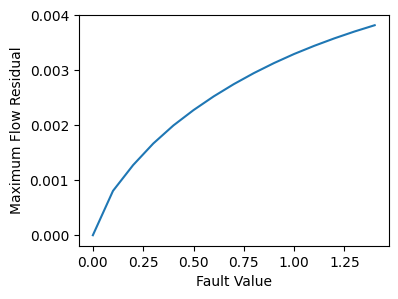

In [54]:
# Fault Severity and maximum residual. 
conduit_names = model_swmm.get_component_names('CONDUITS')
# Loop through components and get slope of fault-residual relationship.
fault_slope = []
for conduit_name in conduit_names:
    flow_residuals = []
    for i, fault_value in enumerate(fault_values):
        # Select data from specific fault value.
        value_df = fault_df.loc[fault_df['fault_value'] == fault_value, :]

        flow_res = value_df[f'Flow_link_{flow_link_id}'] - model_df[f'Flow_link_{flow_link_id}']
        max_flow_residual = np.max(np.abs(residuals))
        flow_residuals.append(max_residual)
    
        
    
    
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(fault_values, max_residuals)
ax.set_xlabel('Fault Value')
ax.set_ylabel('Maximum Flow Residual')

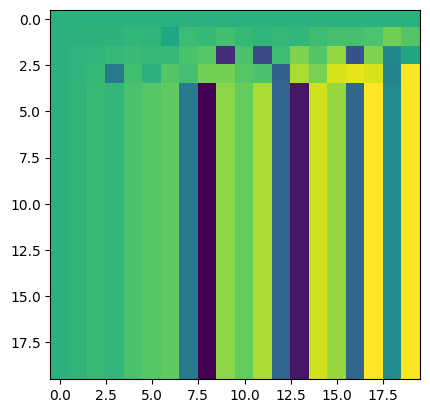

In [37]:
# Fault flow relationship with residuals.
flow_link_id = 10

# Plotting grid.
grid_x, grid_y = np.mgrid[0:0.2:0.01, 0:1:0.05]

# Save points and values.
points = np.zeros((model_df.shape[0] * len(fault_values), 2)) # Fault value, flow rate
values = np.zeros(model_df.shape[0] * len(fault_values)) # Residuals.

# fig, ax = plt.subplots()
for i, fault_value in enumerate(fault_values):
    # Select data from specific fault value.
    value_df = fault_df.loc[fault_df['fault_value'] == fault_value, :]
    
    residuals = value_df[f'Flow_link_{flow_link_id}'] - model_df[f'Flow_link_{flow_link_id}']
    
    points[i*model_df.shape[0]:(i+1) * model_df.shape[0], 0] = value_df[f'Flow_link_{flow_link_id}'] 
    points[i*model_df.shape[0]:(i+1) * model_df.shape[0], 1] = fault_value
    values[i*model_df.shape[0]:(i+1) * model_df.shape[0]] = residuals
    
#     ax.scatter(value_df['fault_value'], value_df[f'Flow_link_{flow_link_id}'], c=residuals)
    
# fig.colorbar(plt.cm.ScalarMappable(),
#              orientation='horizontal',
#              # ax = axes instructs the colormap to extend over all axes
#              ax=ax,
#              # but it's to much, so we shrink it to 75% 
#              shrink=0.75,
#              # and make it a little slimmer
#              aspect=30,
#              )

grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

fig, ax = plt.subplots()
# ax.scatter(points[:,1], points[:,0], c=values)
ax.imshow(grid_z0.T)

C:\Users\ay434\AppData\Local\Temp\ipykernel_11280\3293881158.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
C:\Users\ay434\AppData\Local\Temp\ipykernel_11280\3293881158.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


Text(0, 0.5, 'Node Flooding')

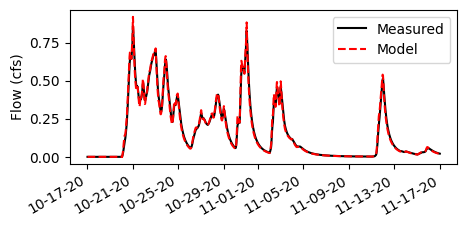

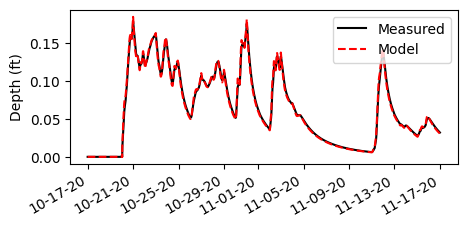

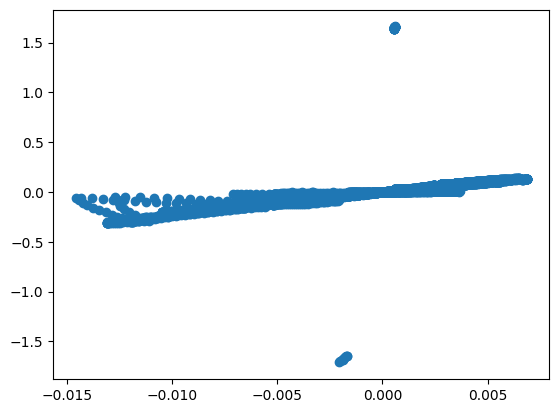

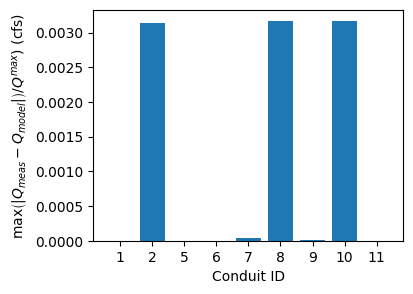

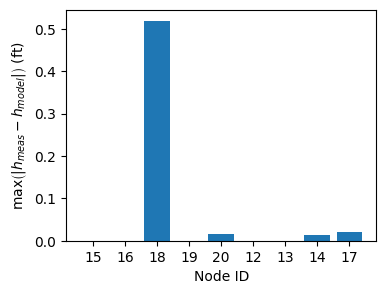

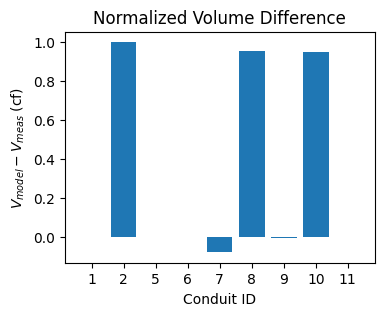

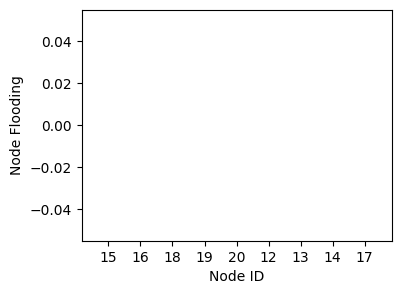

In [192]:
# Plot fault and healthy flow time series.
flow_link_id = 10
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(model_df['datetime'], fault_df[f'Flow_link_{flow_link_id}'], 'k', label='Measured')
ax.plot(model_df['datetime'], model_df[f'Flow_link_{flow_link_id}'], 'r--', label='Model')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend()
ax.set_ylabel('Flow (cfs)')

# Plot fault and healthy depth time series.
depth_node_id = 14
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(model_df['datetime'], fault_df[f'Depth_node_{depth_node_id}'], 'k', label='Measured')
ax.plot(model_df['datetime'], model_df[f'Depth_node_{depth_node_id}'], 'r--', label='Model')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend()
ax.set_ylabel('Depth (ft)')

# Plot depth residual vs. velocity residual.
v_residual = fault_df[f'Velocity_link_{flow_link_id}'] - model_df[f'Velocity_link_{flow_link_id}']
d_residual = fault_df[f'Depth_link_{flow_link_id}'] - model_df[f'Depth_link_{flow_link_id}']
fig, ax = plt.subplots()
ax.scatter(d_residual, v_residual)

# Plot maximum and minimum flow residual value for each conduit.
conduit_names = model_swmm.get_component_names('CONDUITS')
max_flow_residual = []
for i, cname in enumerate(conduit_names):
    # Get the conduit geometry.
    geom = model_swmm.get_link_geometry(cname)
    
    # Max flow rate ~ 1.393 D^3.
    Qmax = geom[0]**3
    
    # Residuals.
    residual = fault_df[f'Flow_link_{cname}'] - model_df[f'Flow_link_{cname}']
    
    # Normalize by maximum possible (unpressurized) flow.
    norm_abs_residual = np.abs(residual) / Qmax
    
    # Maximum residual value.
    max_residual = np.max(norm_abs_residual)
    max_flow_residual.append(max_residual)
    
fig, ax = plt.subplots(figsize=(4,3))
ax.bar(conduit_names, max_flow_residual) 
ax.set_xlabel('Conduit ID')
ax.set_ylabel('max$\\left(|Q_{meas} - Q_{model}|\\right) / Q^{max})$ (cfs)')

# Plot maximum head residual value for each node.
node_names = model_swmm.get_component_names('JUNCTIONS')
node_names.extend(model_swmm.get_component_names('OUTFALLS'))
max_head_residual = []
for i, node_name in enumerate(node_names):
    max_head_residual.append(np.max(np.abs(fault_df[f'Depth_node_{node_name}'] - model_df[f'Depth_node_{node_name}'])))
    
fig, ax = plt.subplots(figsize=(4,3))
ax.bar(node_names, max_head_residual) 
ax.set_xlabel('Node ID')
ax.set_ylabel('max$\\left(|h_{meas} - h_{model}|\\right)$ (ft)')

# Plot the difference in cumulative volume through each conduit.
volume_diff = []
for i, cname in enumerate(conduit_names):
    volume_diff.append((np.sum(model_df[f'Flow_link_{cname}']) - np.sum(fault_df[f'Flow_link_{cname}'])))
    
fig, ax = plt.subplots(figsize=(4,3))
ax.bar(conduit_names, volume_diff) 
ax.set_xlabel('Conduit ID')
ax.set_ylabel('$V_{model} - V_{meas}$ (cf)')
ax.set_title('Normalized Volume Difference')

# Plot node flooding.
node_flooding = []
for i, node_name in enumerate(node_names):
    node_flooding.append(np.sum(fault_df[f'Flood_node_{node_name}']))
    
fig, ax = plt.subplots(figsize=(4,3))
ax.bar(node_names, node_flooding) 
ax.set_xlabel('Node ID')
ax.set_ylabel('Node Flooding') 